In [113]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import math
import json
from nltk import tokenize
import collections
import re
import itertools
import nltk
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel,\
        GenericLikelihoodModelResults

from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.special import zeta
from scipy.stats import binom

import pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

lg = np.log10

In [201]:
test = pd.read_csv (r'data/webtext.test.csv')
test = test.dropna()
test = test['text'].tolist()
# test_file = make_file(test)

In [208]:
sep_corps = [make_file(corpus, multi = False) for corpus in test]

In [213]:
train = pd.read_csv (r'data/webtext.train.csv')

In [212]:
train.loc[train['length']>= 900]

,id,ended,length,text
13,255013,True,953,Get Liverpool FC updates directly to your inbo...
21,255021,False,1024,The Wolf currently has the former Seminole as ...
22,255022,False,1024,The Obama administration is being slammed from...
25,255025,True,901,Major events in the history of SGI and Priesth...
26,255026,False,1024,When the head of the CIA's torture unit decide...
...,...,...,...,...
4970,259970,False,1024,"Listen to a recording of the complete speech, ..."
4980,259980,False,1024,"PORT ANGELES, WA— A single moment won't define..."
4985,259985,False,1024,Please enable Javascript to watch this video\n...
4992,259992,False,1024,New Year's Eve Party 2018 at The Drake Hotel -...


In [2]:
web_train = pd.read_csv (r'data/webtext.train.csv')
web_train = web_train.loc[web_train['length']>= 1000]
web_train = web_train.dropna()
web_train = web_train['text'].tolist()

In [3]:
web_train_1000 = web_train[:1000]

In [212]:
web_train_1000_2 = web_train[1000:2000]

In [8]:
web_train_pos = [make_file(text, multi=False, pos=True) for text in web_train_1000]

In [213]:
web_train_pos_2 = [make_file(text, multi=False, pos=True) for text in web_train_1000_2]

In [214]:
pickle.dump(web_train_pos_2, open( "web_1000_pos_2.p", "wb" ))

In [15]:
web_train_sents = [item for sublist in web_train_pos for item in sublist]

In [10]:
gpt_train = pd.read_csv (r'data/small-117M-k40.train.csv')
gpt_train = gpt_train.loc[gpt_train['length']>= 1000]
gpt_train = gpt_train.dropna()
gpt_train = gpt_train['text'].tolist()

In [11]:
gpt_train_1000 = gpt_train[:1000]

In [282]:
gpt_train_pos_1 = pickle.load(open("gpt_1000_pos.p", "rb" ))

In [234]:
gpt_train_pos_2[0][0]

[('puerto', 'NNP'), ('rico', 'NNP'), ('gov', 'NNP')]

In [283]:
gpt_train_pos_2 = pickle.load(open("gpt_1000_pos_2.p", "rb" ))

In [12]:
gpt_train_pos = [make_file(text, multi=False, pos=True) for text in gpt_train_1000]

In [222]:
pickle.dump(gpt_train_pos, open( "gpt_1000_pos_2.p", "wb" ))

In [16]:
gpt_train_sents = [item for sublist in gpt_train_pos for item in sublist]

## Data processing

In [17]:
# Pre-processing without part of speech tags
def remove_punctuation(text):
    text = text.lower()
    chars_to_remove = "[\n]!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    tr = str.maketrans(" ", " ", chars_to_remove)
    return text.translate(tr)


def preprocess(corpus, sent = True):
    if sent:
        corpus = tokenize.sent_tokenize(corpus)
        corpus = [remove_punctuation(sent).split() for sent in corpus]
    else:
        corpus = remove_punctuation(corpus).split()
    return corpus

In [18]:
# Pre-processing with part of speech tags
def part_of_speech(corpus):
    corpus = tokenize.sent_tokenize(corpus)
    chars_to_remove = "[\n]"
    tr = str.maketrans(" ", " ", chars_to_remove)
    chars_to_remove2 = "[\n]!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    new_corp = []
    test = []

    for sent in corpus:
        sent = sent.translate(tr)
        words_sent = tokenize.word_tokenize(sent)
        sent_pos = nltk.pos_tag(words_sent)
        new_sent = []
        for (word, pos) in sent_pos:
            tr2 = str.maketrans("", "", chars_to_remove2)
            word = word.translate(tr2)
            if word:
                new_sent.append((word.lower(), pos))
        new_corp.append(new_sent)
    return new_corp

In [19]:
# Total preprocessing function for a corpus. Input can be one string (corpus),
# for which you put multi = False, or a list of several strings (corpora) that 
# you want to turn into one big corpus, for which you put multi = True.
# For PoS tags, put pos = True.
def make_file(corp, multi = True, sent = True, pos = False):
    if multi:
        corpus = ''
        for subcorp in corp:
            corpus += subcorp
    else:
        corpus = corp
        
    if pos:
        corpus = part_of_speech(corpus)
    
    else:
        corpus = preprocess(corpus, sent = sent)
    
    return corpus

## Webtext test files

In [79]:
real_test = pd.read_csv (r'data/webtext.test.csv')
real_test = real_test.dropna()
real_test = real_test['text'].tolist()

In [356]:
real_test_1 = pickle.load(open("real_test_1.p", "rb" ))

In [357]:
real_test_2 = pickle.load(open("real_test_2.p", "rb" ))

In [52]:
real_test_3 = pickle.load(open("real_test_3.p", "rb" ))

In [53]:
real_test_4 = pickle.load(open("real_test_4.p", "rb" ))

In [54]:
real_test_5 = pickle.load(open("real_test_5.p", "rb" ))

## GPT test files

In [90]:
k40_test = pd.read_csv (r'data/small-117M-k40.test.csv')
k40_test = k40_test.dropna()
k40_test = k40_test['text'].tolist()

In [358]:
k40_test_1 = pickle.load(open("k40_test_1.p", "rb" ))

In [359]:
k40_test_2 = pickle.load(open("k40_test_2.p", "rb" ))

In [57]:
k40_test_3 = pickle.load(open("k40_test_3.p", "rb" ))

In [58]:
k40_test_4 = pickle.load(open("k40_test_4.p", "rb" ))

In [59]:
k40_test_5 = pickle.load(open("k40_test_5.p", "rb" ))

## Creating the data

### Webtext

In [102]:
gpt_real = pd.read_csv (r'data/webtext.train.csv')
gpt_real = gpt_real.dropna()
gpt_real = gpt_real['text'].tolist()

In [ ]:
# real_file = make_file(gpt_real[:50000])

In [43]:
# real_2 = make_file(gpt_real[50000:100000])

In [ ]:
# real_3 = make_file(gpt_real[100000:150000])

In [ ]:
# real_4 = make_file(gpt_real[150000:200000])

In [ ]:
# real_5 = make_file(gpt_real[200000:250000])

In [162]:
real_pos_1 = pickle.load(open("real_pos_1.p", "rb" ))

In [3]:
real_pos_2 = pickle.load(open("real_pos_2.p", "rb" ))

In [4]:
real_pos_3 = pickle.load(open("real_pos_3.p", "rb" ))

In [5]:
real_pos_4 = pickle.load(open("real_pos_4.p", "rb" ))

In [5]:
real_pos_5 = pickle.load(open("real_pos_5.p", "rb" ))

In [132]:
# pickle.dump(real_pos_5, open( "real_pos_5.p", "wb" ))

### GPT Small K40

In [43]:
gpt_small_k40 = pd.read_csv (r'data/small-117M-k40.train.csv')
gpt_small_k40 = gpt_small_k40.dropna()
gpt_small_k40 = gpt_small_k40['text'].tolist()

In [97]:
gpt_small_k40_pos_1 = pickle.load(open("gpt_small_k40_pos_1.p", "rb"))

In [98]:
gpt_small_k40_pos_2 = pickle.load(open("gpt_small_k40_pos_2.p", "rb"))

In [9]:
gpt_small_k40_pos_3 = pickle.load(open("gpt_small_k40_pos_3.p", "rb"))

In [6]:
gpt_small_k40_pos_4 = pickle.load(open("gpt_small_k40_pos_4.p", "rb"))

In [44]:
k40_5 = make_file(gpt_small_k40[200000:250000], pos = True)

In [45]:
pickle.dump(k40_5, open("gpt_small_k40_pos_5.p", "wb"))

In [141]:
# gpt_small_k40_pos_5 = pickle.load(open("gpt_small_k40_pos_5.p", "rb"))

### GPT Small Temperature

In [27]:
gpt_small_temp = pd.read_csv (r'data/small-117M.train.csv')
gpt_small_temp = gpt_small_temp.dropna()
gpt_small_temp = gpt_small_temp['text']

In [ ]:
# gpt_small_temp_1 = make_file(gpt_small_temp[0:50000].tolist())

### Subsampling

In [20]:
# Returns 2 lists of corpora, one from which the ranks will be calculated
# and one from which the frequencies will be calculated. Each corpus consists of
# a list of tokenized sentences.
# Input: corpus that is to be subsampled. Should be a list of tokenized sentences.
# k is the amount of tokens that each sampled corpus should contain,
# m is the amount of subcorpera you want for both the ranks and frequencies.
# Max: I would read Valentin's thesis for an explanation on subsampling
def subsampling(corpus, k = 1000000, m = 10, sent = True):
    n = len(corpus)
    
    sen_len = {}

    
    rank_corpera = []
    freq_corpera = []

    if sent:
        for i in range(m):
            used_rank = set()
            used_freq = set()
            rank_count = 0
            freq_count = 0
            rank_samples = []
            freq_samples = []

            while rank_count < k:
                index = np.random.randint(n)
                if index in used_rank:
                    continue

                rank_sample = corpus[index]
                len_sample = len(rank_sample)

                if len_sample == 0:
                    continue

                rank_samples += rank_sample
                rank_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1


                used_rank.add(index)

            while freq_count < k:
                index = np.random.randint(n)
                if index in used_freq:
                    continue
                freq_sample = corpus[index]
                len_sample = len(freq_sample)

                if len_sample == 0:
                    continue

                freq_samples += freq_sample
                freq_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1

                used_freq.add(index)

            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
#                 rank_corpera.append([item for sublist in rank_samples for item in sublist])
#                 freq_corpera.append([item for sublist in freq_samples for item in sublist])


    else:
        for i in range(m):
            rank_samples = random.sample(corpus, k)
            freq_samples = random.sample(corpus, k)
            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
    
#     return rank_corpera, freq_corpera, sen_len
    return rank_corpera, freq_corpera

### Calculating the frequencies

In [23]:
# Returns a dataframe of word frequencies for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_freqs(freq_sents):
    freq_dict = {}
    for i, corpus in enumerate(freq_sents):
        freq_dict[i] = collections.Counter(corpus)
        
    freqs_df = pd.DataFrame(freq_dict)
    freqs_df = freqs_df.fillna(0)
    
    return freqs_df

In [24]:
# Returns a dataframe with the mean frequency of each word across different corpora.
# Input: frequency dataframe
def mean_freqs(freqs_df):
    return(freqs_df.mean(axis=1))

### Calculating the ranks

In [25]:
# Returns a dataframe of word ranks for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_ranks(rank_sents):
    ranks_dicts = {}
    for i, corpus in enumerate(rank_sents):
        freqs = collections.Counter(corpus)
        ranks_dicts[i] = {w: r for r, (w, c) in enumerate(freqs.most_common(), 1)}
        
    ranks_df = pd.DataFrame(ranks_dicts)
    for column in ranks_df:
        min_rank = int(np.ceil(ranks_df[column].max() + 1))
        nan_rows = ranks_df[ranks_df[column].isnull()]
        num_nans = len(nan_rows)
        nan_ranks = list(range(min_rank, min_rank+num_nans))
        random.shuffle(nan_ranks)
        ranks_df.loc[ranks_df[column].isnull(), column] = nan_ranks

    return ranks_df

In [26]:
# Returns a dataframe with the mean rank of each word across different corpora.
# Input: rank dataframe
def mean_ranks(ranks_df):
    return ranks_df.mean(axis=1)

In [27]:
# Creates combined dataframe of ranks and frequencies
# Input: 2 lists (freq_sents and rank_sents) of corpora. Each corpus
# consists of a list of tokenized sentences. These lists are to be obtained form
# subsampling.
def ranks_freqs(freq_sents, rank_sents):
    freqs_df = calculate_freqs(freq_sents)
    freqs_df['Frequency'] = mean_freqs(freqs_df)
    ranks_df = calculate_ranks(rank_sents)
    ranks_df['Rank'] = mean_ranks(ranks_df)
    
    # Put mean ranks and freqs together and remove all words that
    # do not have both a rank and frequency (which happens when a word)
    # is only present in freq_sents and not in rank_sents or vice versa
    ranks_freqs_df = pd.concat([ranks_df, freqs_df], axis = 1)
    ranks_freqs_df = ranks_freqs_df.dropna()
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
    return ranks_freqs_df

In [28]:
def freq_of_freqs_hist_plot(freqs):
    freq_of_freqs = collections.Counter(freqs)
    plt.bar(list(freq_of_freqs.keys()), freq_of_freqs.values(), color='b')
    plt.show()
    return None

In [29]:
def freq_of_freqs_hexbin_plot(freqs):
    freq_of_freqs = collections.Counter(freqs)
    hexbin_plot(list(freq_of_freqs.keys()), freq_of_freqs.values())
    plt.show()
    return None

## Fano factor

In [30]:
def fano_factor(ranks_freqs_df, ylim = None):
    fano = []

    for index, row in ranks_freqs_df.iterrows():
        fano.append((np.cov(row[0:10], row[11:21])[0][1])/row['Rank'])
    ranks_freqs_df['Fano'] = fano
#     fano_plot(ranks_freqs_df, ylim=ylim)
    return ranks_freqs_df

### Estimating Zipf's law

We estimate Zipf's law using $f(w) \propto \frac{1}{r(w)^{\alpha}}$. In the following code block, the $\alpha$ is found using maximum likelihood estimation, for which the code was taken from https://stats.stackexchange.com/questions/6780/how-to-calculate-zipfs-law-coefficient-from-a-set-of-top-frequencies .

In [32]:
# MLE of Zipf's law parameters (alpha and beta)
class Mandelbrot(GenericLikelihoodModel):

    def __init__(self, frequencies, ranks, **kwargs):
        if not len(frequencies) == len(ranks):
            raise ValueError("NOT THE SAME NUMBER OF RANKS AND FREQS!")
        
        frequencies = np.asarray(frequencies)
        ranks = np.asarray(ranks)
        
        self.n_obs = np.sum(frequencies)
        
        super().__init__(endog=frequencies, exog=ranks, **kwargs)
        self.fit_result = None
    

    def prob(self, params, ranks=None, log=False):
        if ranks is None:
            ranks = self.exog
        
        alpha, beta = params
        if log:
            return -alpha*lg(beta+ranks) - lg(zeta(alpha, q=beta+1.))
        else:
            return ((beta + ranks)**(-alpha))/zeta(alpha, q=beta+1.)
    
    
    def loglike(self, params):
        rs = self.exog
        fs = self.endog
        alpha, beta = params
        
#        if alpha > 10 or beta > 20:
#            return -np.inf
        
#         if alpha < 1.0 or beta < 0.0:
#             return -np.inf
        
        # no need to calculate P(r) when observed f(r) was zero
        log_probs = -alpha*lg(beta+rs) - lg(zeta(alpha, q=beta+1.))
        log_probs = log_probs.reshape(-1, )
        return np.sum(fs * log_probs) - beta**5
    
    
    def register_fit(self, fit_result, overwrite=False):
        if not self.fit_result is None and not overwrite:
            raise ValueError("A fit result is already registered and overwrite=False!")
            
        self.fit_result = fit_result
        self.optim_params = fit_result.params
        self.pseudo_r_squared = self.pseudo_r_squared(self.optim_params)
        self.SE, self.SE_relative = fit_result.bse, fit_result.bse/self.optim_params
        self.BIC, self.BIC_relative = fit_result.bic,\
                            (-2*self.null_loglike())/fit_result.bic
        
        return self.optim_params
    
    def print_result(self, string=False):
        if self.fit_result is None:
            raise ValueError("Register a fitting result first!")

        def format_x(x):
            return float('{0:.3g}'.format(x))


        s = "="*50
        s += "\n" + "MANDELBROT"
        s += "\n" + "  Optimal Parameters " + str(tuple(map(format_x, self.optim_params)))
        
        s += "\n" + "  Standard Error [relative]: " + str(tuple(map(format_x, self.SE))) +\
              ", [" + str(tuple(map(format_x, self.SE_relative))) + "]"
        
        s += "\n" + "  Pseudo R^2: " + str(format_x(self.pseudo_r_squared))
        
        s += "\n" + "  BIC [relative]: " + str(format_x(self.BIC)) +\
              ", [" + str(format_x(self.BIC_relative)) + "]"
        s += "\n" + "="*50
        
        if string:
            return s
        
        print(s)
    
    
    def null_loglike(self, epsilon=1e-10):
        return self.loglike((1.+epsilon, 0.0))
    
    def pseudo_r_squared(self, params):
        return 1-self.loglike(params)/self.null_loglike()
    
    
    def predict(self, params, ranks=None, freqs=True, n_obs=None, 
                correct_for_finite_domain=True):
        if ranks is None:
            ranks = self.exog
        ranks = np.asarray(ranks)
        
        if n_obs is None:
            n_obs = self.n_obs
            
        alpha, beta = params
        pred_probs = self.prob(params, ranks=ranks, log=False)
        
        if correct_for_finite_domain:
            if not freqs:
                raise NotImplementedError("Correction for "\
                                          "finite domain not implemented with probabilities!")
            return pred_probs*(n_obs/np.sum(pred_probs))
        
        if freqs:
            return n_obs*pred_probs
        
        return pred_probs



In [34]:
# Returns a dataframe containing the mean frequencies and ranks, as well as 
# the estimated frequencies from Zipf's law and the error between the (log) mean
# frequencies and (log) estimated frequencies.
def zipfs_law(df):
    mandelbrot = Mandelbrot(df['Frequency'], df['Rank'])
    mandelbrot_fit = mandelbrot.fit(start_params=np.asarray([1.0, 1.0]), # [1.0, 1.0]
                                method="powell", full_output=True, disp=0)
    mandelbrot.register_fit(mandelbrot_fit)
    mandelbrot.print_result()
    
    model_params = mandelbrot.optim_params
    alpha, beta =  mandelbrot.optim_params
    preds = mandelbrot.predict(model_params, df['Rank'])

    df['Estimated frequency'] = preds
    df['Rank (log)'] = np.log(df['Rank'])
    df['Frequency (log)'] = np.log(df['Frequency'])
    df['Estimated frequency (log)'] = np.log(df['Estimated frequency'])
    df['Error'] = df['Frequency (log)'] - df['Estimated frequency (log)']
    return df

## Voor Max:
Om van een corpus (= een lijst van tokenized zinnen) een dataframe met Zipf's law te krijgen moet je dit runnen (geeft zo natuurlijk errors dus moet je nog invullen):

In [379]:
# 'corpus' is dus een lijst van tokenized zinnen. k en m kan je zelf invullen of 
# default gebruiken.
rank_corpora, freq_corpora = subsampling(corpus, k=?, m=?)
ranks_freqs_df = ranks_freqs(rank_corpora, freq_corpora)
# Hieruit krijg je dus een dataframe met voor elk woord de rank, frequency,
# estimated frequency volgens Zipf's law en de error.
zipf_df = zipfs_law(ranks_freqs_df)

# Plotting (code from Valentin's thesis)

In [35]:
def get_lims(xs, ys, log=False, equal_aspect=False):
    lows = min(xs), min(ys)
    highs = max(xs), max(ys)
    
    if log:
        c_low, c_high = (lambda x: x*0.5), (lambda x: x*1.5)   
    else:
        c_low, c_high = (lambda x: x*0.6), (lambda x: x*1.05)   
    
    if log:
        lows = tuple(max(10**-10, l) for l in lows)
    
    if equal_aspect:
        lims = (c_low(min(lows)),)*2, (c_high(max(highs)),)*2
        return list(zip(*lims))
    
    return (c_low(lows[0]), c_high(highs[0])),\
                (c_low(lows[1]), c_high(highs[1]))

In [36]:
def remove_zeros(x_vals, y_vals):
    return list(zip(*[(x, y) for x, y in zip(x_vals, y_vals) 
                      if x > 0 and y > 0]))

In [37]:
def fano_plot(ranks_freqs_df, ylim = None, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    ranks_freqs_filt = ranks_freqs_df.loc[(ranks_freqs_df['Fano'] >= -5) & (ranks_freqs_df['Fano'] <= 5)]
    xs = ranks_freqs_filt['Rank']
    ys = ranks_freqs_filt['Fano']
    
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
#     plt.xlim(lims_x)
#     plt.ylim(lims_y)
    if ylim:
        plt.ylim(ylim)
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
        
    return lims

In [40]:
def type_plot(df, word_type, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    xs = df['Rank']
    ys = df['Frequency']
    est = df['Estimated frequency']
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    type_df = df.query('ilevel_1 == @word_type')
    params2 = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                linewidths=0.2)
    hb2 = plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
        plt.gcf().colorbar(hb2)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
        
    plt.plot(xs, est, color='r', linestyle="--")
        
    return lims

In [41]:
def hexbin_plot(xs, ys, est=None, word_type=None, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if word_type:
        type_df = df.query('ilevel_1 == @word_type')
        params2 = dict(color = 'red', gridsize=75, mincnt=1,
                  linewidths=0.2)
        plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
        
    if est is not None:
        plt.plot(xs, est, color='r', linestyle="--")
        
    return lims

In [42]:
def hexbin_error(xs, ys, xlbl=None, ylbl=None,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    

    # cmap='cividis'
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)

    plt.ticklabel_format(style="sci", axis="both", 
                            scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
    plt.ylim([-2,2])
        
    plt.axhline(linewidth=1.5, color='r', linestyle="--")
        
    return None

In [43]:
def plot_type_zipf(df, word_type):
    type_df = df.query('ilevel_1 == @word_type')
    zipf_type = zipfs_law(type_df)
    plt.title("{}".format(word_type))
    hexbin_plot(zipf_type['Rank'], zipf_type['Frequency'], zipf_type['Estimated frequency'])
    plt.show()
    hexbin_error(zipf_type['Rank (log)'], zipf_type['Error'])
    plt.show()
    
    return zipf_type

In [44]:
def plot_zipf(ranks_freqs_df):
    ranks_freqs_df = ranks_freqs_df.sort_values(by=['Rank'])
    zipf_df = zipfs_law(ranks_freqs_df)
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
#     hexbin_plot(ranks_freqs_df['Rank'], ranks_freqs_df['Frequency'], est = ranks_freqs_df['Estimated frequency'])
#     plt.show()
#     hexbin_error(zipf_df['Rank (log)'], zipf_df['Error'])
#     plt.show()
    
    return zipf_df

# PoS

In [196]:
df_real_1 = pickle.load(open('df_real_1.pkl', 'rb'))
df_real_2 = pickle.load(open('df_real_2.pkl', 'rb'))
df_real_3 = pickle.load(open('df_real_3.pkl', 'rb'))
df_real_4 = pickle.load(open('df_real_4.pkl', 'rb'))
df_real_5 = pickle.load(open('df_real_5.pkl', 'rb'))

In [197]:
df_k40_1 = pickle.load(open('df_k40_1.pkl', 'rb'))
df_k40_2 = pickle.load(open('df_k40_2.pkl', 'rb'))
df_k40_3 = pickle.load(open('df_k40_3.pkl', 'rb'))
df_k40_4 = pickle.load(open('df_k40_4.pkl', 'rb'))
df_k40_5 = pickle.load(open('df_k40_5.pkl', 'rb'))

In [31]:
real_dfs = [df_real_1, df_real_2, df_real_3, df_real_4]
k40_dfs = [df_k40_1, df_k40_2, df_k40_3, df_k40_4]

In [26]:
df_real_1.index.unique(level=1)

Index(['DT', 'TO', 'IN', 'CC', 'VBZ', 'PRP', 'VBD', 'VBP', 'VB', 'RB', 'PRP$',
       'WDT', 'MD', 'WP', 'CD', 'WRB', 'VBN', 'EX', 'JJ', 'NNS', 'NN', 'RP',
       'JJR', 'RBR', 'VBG', 'NNP', 'RBS', 'JJS', 'PDT', 'NNPS', 'WP$', 'UH',
       'FW', 'LS', '$', 'SYM', 'POS', ''''],
      dtype='object')

OPEN<br>
NN = noun, common, singular or mass<br>
NNS = noun, common, plural<br>
NNP = noun, proper, singular<br><br>

VBD = verb, past tense<br>
VBP = verb, present tense, not 3rd person singular<br>
VBG = verb, present participle or gerund<br>
VB = verb, base form<br>
VBZ = verb, present tense, 3rd person singular <br>
VBN = verb, past participle<br><br>

JJ = adjective or numeral, ordinal<br>
JJR = adjective, comparative<br>
JJS = adjective, superlative<br><br>

RB: adverb<br>
RBR: adverb, comparative<br>
RBS: adverb, superlative<br><br>

CLOSED <br>
DT = determiner <br>
TO = to
IN = preposition or conjunction
CC = numeral, cardinal
VBZ = verb, present tense, 3rd person singular
PRP = pronoun, personal
RB = particle
PRP$ = pronoun, possessive
WDT = WH-determiner
MD = modal auxiliary
WP = WH-pronoun


In [46]:
# nouns_real_1 = df_real_1.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'")
real_noun_dfs = [df.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'") for df in real_dfs]
real_not_noun_dfs = [df.query("ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'") for df in real_dfs]

real_verb_dfs = [df.query("ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'") for df in real_dfs]
real_not_verb_dfs = [df.query("ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'") for df in real_dfs]

real_adj_dfs = [df.query("ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'") for df in real_dfs]
real_not_adj_dfs = [df.query("ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'") for df in real_dfs]

real_adv_dfs = [df.query("ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'") for df in real_dfs]
real_not_adv_dfs = [df.query("ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'") for df in real_dfs]


k40_noun_dfs = [df.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'") for df in k40_dfs]
k40_not_noun_dfs = [df.query("ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'") for df in k40_dfs]

k40_verb_dfs = [df.query("ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'") for df in k40_dfs]
k40_not_verb_dfs = [df.query("ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'") for df in k40_dfs]

k40_adj_dfs = [df.query("ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'") for df in k40_dfs]
k40_not_adj_dfs = [df.query("ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'") for df in k40_dfs]

k40_adv_dfs = [df.query("ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'") for df in k40_dfs]
k40_not_adv_dfs = [df.query("ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'") for df in k40_dfs]


real_types_df = [real_noun_dfs, real_verb_dfs, real_adj_dfs, real_adv_dfs]
real_not_types_df = [real_not_noun_dfs, real_not_verb_dfs, real_not_adj_dfs, real_not_adv_dfs]

k40_types_df = [k40_noun_dfs, k40_verb_dfs, k40_adj_dfs, k40_adv_dfs]
k40_not_types_df = [k40_not_noun_dfs, k40_not_verb_dfs, k40_not_adj_dfs, k40_not_adv_dfs]

titles = ["Nouns", "Verbs", "Adjectives", "Adverbs"]
saves = ["nouns_", "verbs_", "adjectives_", "adverbs_"]

In [65]:
for i, query in enumerate(queries1):
    for j, real in enumerate(real_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in Real Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()
        
        hexbin_error(type_df['Rank (log)'], type_df['Error'])
        plt.title("Error of {} in Real Text {}".format(titles[i], j+1))
        plt.savefig(saves[i] + "error_real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [67]:
for i, query in enumerate(queries1):
    for j, real in enumerate(k40_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in GPT Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "k40_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()
        
        hexbin_error(type_df['Rank (log)'], type_df['Error'])
        plt.title("Error of {} in GPT Text {}".format(titles[i], j+1))
        plt.savefig(saves[i] + "error_k40_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [58]:
queries1 = ["ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'", 
            "ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'",
           "ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'", 
           "ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'"]

queries2 = ["ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'", 
            "ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'",
           "ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'", 
           "ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'"]

titles = ["Nouns", "Verbs", "Adjectives", "Adverbs"]
saves = ["nouns_", "verbs_", "adjectives_", "adverbs_"]

In [37]:
# queries1 = ["ilevel_1 == 'NN' or ilevel_1 == 'NNS'", 
#             "ilevel_1 == 'NNP'", "ilevel_1 == 'VB'", "ilevel_1 == 'VBD'", 
#             "ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'", ]

# queries2 = ["ilevel_1 != 'NN' and ilevel_1 != 'NNS'", 
#             "ilevel_1 != 'NNP'", "ilevel_1 != 'VB'", "ilevel_1 != 'VBD'",
#            "ilevel_1 != 'VBP'"]

# titles = ["Common Nouns", "Proper Nouns", "Verbs Base Form", "Verbs Past Tense",
#          "Verbs Present Tense"]

# saves = ["common_nouns_", "proper_nouns_", "verbs_base_", "verbs_past_",
#         "verbs_present_"]

# # queries1 = ["ilevel_1 == 'VBD'"]
# # queries2 = ["ilevel_1 != 'VBD'"]
# # titles = ["Verbs Past Tense"]
# # saves = ["verb_past_real_"]

In [60]:
for i, query in enumerate(queries1):
    for j, real in enumerate(real_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in Real Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [34]:
for i, k40 in enumerate(k40_dfs):
    type_df = k40.query("ilevel_1 == 'VBD'")
    rest_df = k40.query("ilevel_1 != 'VBD'")
    hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

    hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
            color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Verbs past tense')
    plt.title("Verbs Past Tense in GPT Text {}".format(i+1))
    plt.legend()
    plt.savefig("verb_past_k40_" + str(i+1) + ".png",
                dpi=300)
    plt.close()

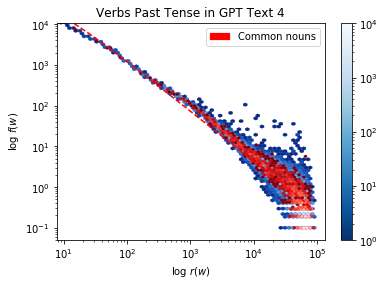

In [33]:
# for i, real in enumerate(real_dfs):
real = df_k40_4
# NN_df = real.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS'")
JJ_df = real.query("ilevel_1 == 'VBD'")
not_real = real.query("ilevel_1 != 'VBD'")
hexbin_plot(not_real['Rank'], not_real['Frequency'], est=not_real['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

hexbin_plot(JJ_df['Rank'], JJ_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
            color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Common nouns')
plt.title("Verbs Past Tense in GPT Text {}".format(i+1))
plt.legend()
# plt.savefig("verb_past_k40_4.png",
#             dpi=300)
# plt.savefig("common_nouns_real_" + i + ".png",
#             dpi=300)

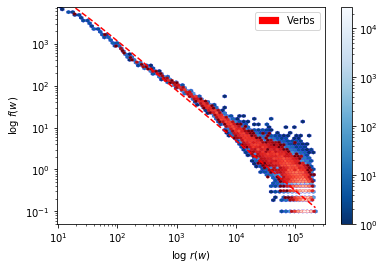

In [95]:
hexbin_plot(real_plot_5['Rank'], real_plot_5['Frequency'], est=real_plot_5['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Verbs')
plt.legend()
plt.savefig("Verbs_real_5.png", dpi=300)

# Tests real text

### 1

In [110]:
df_real_1 = pickle.load(open('df_real_1.pkl', 'rb'))

In [111]:
df_real_1.index.unique(level=1)

Index(['DT', 'TO', 'IN', 'CC', 'VBZ', 'PRP', 'VBD', 'VBP', 'VB', 'RB', 'PRP$',
       'WDT', 'MD', 'WP', 'CD', 'WRB', 'VBN', 'EX', 'JJ', 'NNS', 'NN', 'RP',
       'JJR', 'RBR', 'VBG', 'NNP', 'RBS', 'JJS', 'PDT', 'NNPS', 'WP$', 'UH',
       'FW', 'LS', '$', 'SYM', 'POS', ''''],
      dtype='object')

In [31]:
rank_sents_real_1, freq_sents_real_1, sen_len_real_1 = subsampling(real_pos_1)

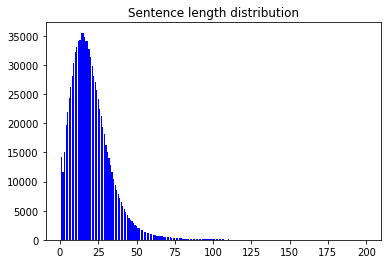

In [32]:
plt.bar(list(sen_len_real_1.keys()), sen_len_real_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [33]:
ranks_freqs_real_1 = ranks_freqs(rank_sents_real_1, freq_sents_real_1)

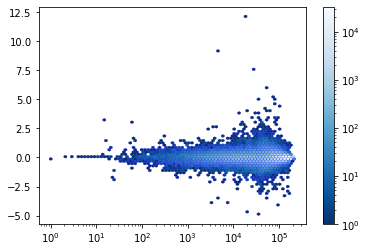

In [34]:
fano_real_1 = fano_factor(ranks_freqs_real_1)

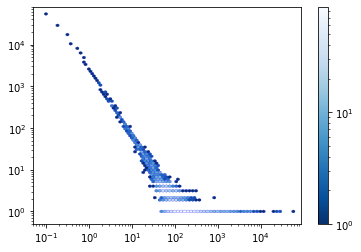

In [70]:
freq_of_freqs_hexbin_plot(real_plot_1['Frequency'])

In [71]:
real_plot_1.to_pickle('df_real_1.pkl')

### 2

In [58]:
rank_sents_real_2, freq_sents_real_2, sen_len_real_2 = subsampling(real_pos_2)

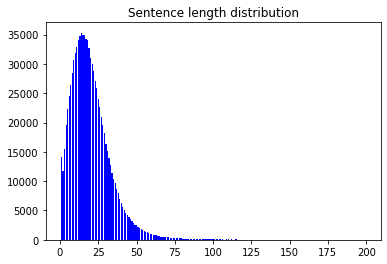

In [59]:
plt.bar(list(sen_len_real_2.keys()), sen_len_real_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [60]:
ranks_freqs_real_2 = ranks_freqs(rank_sents_real_2, freq_sents_real_2)

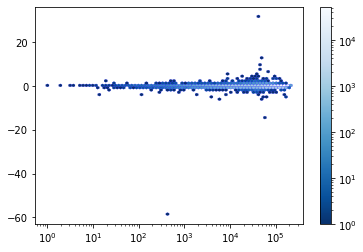

In [61]:
fano_real_2 = fano_factor(ranks_freqs_real_2)

,,0,1,2,3,4,5,6,7,8,9,...,7,8,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,57184.0,57323.0,57569.0,57448.9,0.000000,54222.533931,0.000000,10.958651,10.900852,0.057799
to,TO,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,27596.0,27781.0,28164.0,27899.9,0.000000,41921.050494,0.693147,10.236378,10.643543,-0.407165
of,IN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,25893.0,26116.0,26006.0,26095.2,0.000000,33925.516297,1.098612,10.169507,10.431923,-0.262416
and,CC,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,25284.0,25413.0,25227.0,25389.7,0.000000,28344.426663,1.386294,10.142099,10.252186,-0.110087
a,DT,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,23636.0,23459.0,23373.0,23446.6,0.000000,24245.129017,1.609438,10.062481,10.095971,-0.033490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spectaclehis,JJ,246750.0,233432.0,235807.0,191790.0,197783.0,230486.0,52783.0,253186.0,250026.0,225388.0,...,1.0,0.0,0.0,0.1,0.021747,0.128036,12.263129,-2.302585,-2.055440,-0.247145
townsquare,NNP,195214.0,55788.0,194122.0,249554.0,220167.0,237067.0,256414.0,250449.0,247084.0,213416.0,...,0.0,0.0,0.0,0.1,-0.081862,0.127903,12.264000,-2.302585,-2.056481,-0.246104
rarecasualplay,NNP,247153.0,238557.0,242107.0,253150.0,256554.0,215709.0,178001.0,65407.0,238952.0,186647.0,...,1.0,0.0,0.0,0.1,-0.076867,0.127690,12.265396,-2.302585,-2.058151,-0.244435
unrewarding,VBG,241640.0,253525.0,224952.0,219968.0,226183.0,242416.0,209679.0,251306.0,206382.0,62014.0,...,0.0,0.0,0.0,0.1,-0.002145,0.126561,12.272827,-2.302585,-2.067034,-0.235551


In [118]:
ranks_freqs_df = df_real_1

In [134]:
test = ranks_freqs_df.loc[(ranks_freqs_df['Fano'] >= -5) & (ranks_freqs_df['Fano'] <= 5)]['Fano']

In [135]:
max(test)

4.98946808770704

In [122]:
ranks_freqs_df.loc([(ranks_freqs_df['Fano'] <= 5) | (ranks_freqs_df['Fano'] >= -5)])['Fano']

TypeError: unhashable type: 'list'

In [131]:
max(df_real_1['Fano'])

12.146542433418743

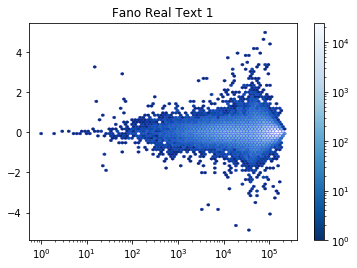

In [145]:
fano_plot(df_real_1)
plt.title("Fano Real Text 1")
plt.savefig("fano_real_1",
            dpi=300)

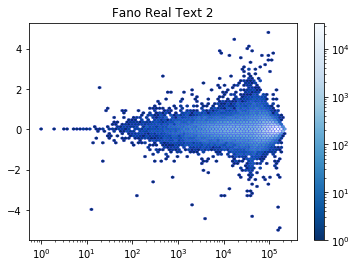

In [147]:
fano_plot(df_real_2)
plt.title("Fano Real Text 2")
plt.savefig("fano_real_2",
            dpi=300)

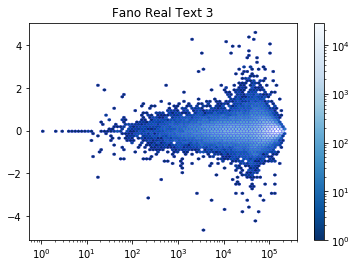

In [150]:
fano_plot(df_real_3)
plt.title("Fano Real Text 3")
plt.savefig("fano_real_3",
            dpi=300)

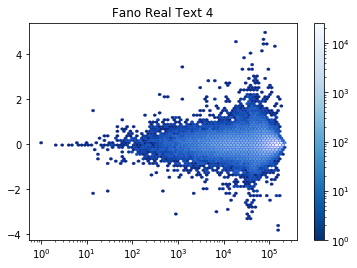

In [151]:
fano_plot(df_real_4)
plt.title("Fano Real Text 4")
plt.savefig("fano_real_4",
            dpi=300)

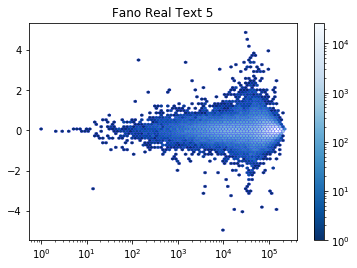

In [152]:
fano_plot(df_real_5)
plt.title("Fano Real Text 5")
plt.savefig("fano_real_5",
            dpi=300)

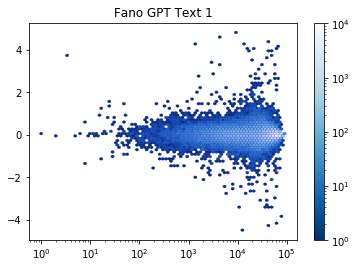

In [153]:
fano_plot(df_k40_1)
plt.title("Fano GPT Text 1")
plt.savefig("fano_k40_1",
            dpi=300)

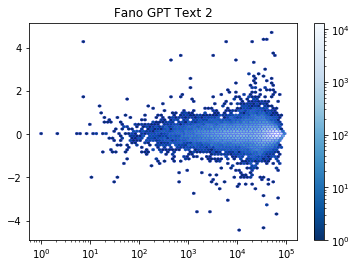

In [154]:
fano_plot(df_k40_2)
plt.title("Fano GPT Text 2")
plt.savefig("fano_k40_2",
            dpi=300)

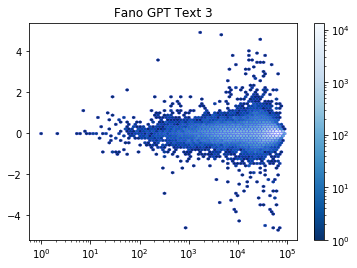

In [155]:
fano_plot(df_k40_3)
plt.title("Fano GPT Text 3")
plt.savefig("fano_k40_3",
            dpi=300)

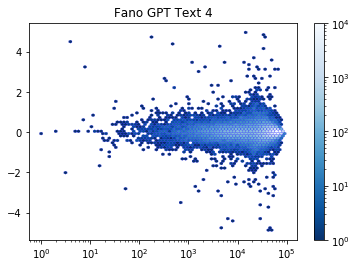

In [156]:
fano_plot(df_k40_4)
plt.title("Fano GPT Text 4")
plt.savefig("fano_k40_4",
            dpi=300)

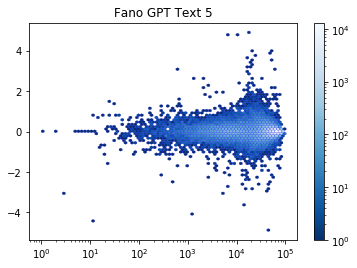

In [157]:
fano_plot(df_k40_5)
plt.title("Fano GPT Text 5")
plt.savefig("fano_k40_5",
            dpi=300)

In [70]:
df_real_1.head(10)

,,0,1,2,3,4,5,6,7,8,9,...,7,8,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,57184.0,57323.0,57569.0,57448.9,0.0,54222.533931,0.000000,10.958651,10.900852,0.057799
to,TO,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,27596.0,27781.0,28164.0,27899.9,0.0,41921.050494,0.693147,10.236378,10.643543,-0.407165
of,IN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,25893.0,26116.0,26006.0,26095.2,0.0,33925.516297,1.098612,10.169507,10.431923,-0.262416
and,CC,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,25284.0,25413.0,25227.0,25389.7,0.0,28344.426663,1.386294,10.142099,10.252186,-0.110087
a,DT,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,23636.0,23459.0,23373.0,23446.6,0.0,24245.129017,1.609438,10.062481,10.095971,-0.033490
in,IN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,19000.0,19050.0,18899.0,18949.7,0.0,21116.886661,1.791759,9.849543,9.957828,-0.108285
is,VBZ,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,11182.0,11227.0,11269.0,11310.5,0.0,18657.555266,1.945910,9.333487,9.834006,-0.500520
for,IN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,10012.0,10047.0,10010.0,10066.0,0.0,16677.456010,2.079442,9.216919,9.721813,-0.504894
it,PRP,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,8787.0,8849.0,8816.0,8811.3,0.0,15051.764869,2.197225,9.083790,9.619251,-0.535460
on,IN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,8306.0,8184.0,8222.0,8175.5,0.0,13695.123765,2.302585,9.008897,9.524795,-0.515898


In [169]:
df_real_1['Rank']

the             DT          1.0
to              TO          2.0
of              IN          3.0
and             CC          4.0
a               DT          5.0
                         ...   
spectaclehis    JJ     211743.1
townsquare      NNP    211927.5
rarecasualplay  NNP    212223.7
unrewarding     VBG    213806.5
kyriazis        NNP    214614.5
Name: Rank, Length: 179741, dtype: float64

In [176]:
df_real_1['Round'] = round(df_real_1['Rank'], 0).astype(int)
df_k40_1['Round'] = round(df_k40_1['Rank'], 0).astype(int)

In [181]:
df_real_1['Round'][50:100]

what     WP       51
also     RB       52
there    EX       53
other    JJ       56
some     DT       56
its      PRP$     57
people   NNS      59
than     IN       59
time     NN       60
our      PRP$     61
up       RP       62
just     RB       62
my       PRP$     62
more     JJR      63
after    IN       63
have     VB       65
into     IN       66
she      PRP      68
so       RB       68
like     IN       69
do       VBP      70
no       DT       72
them     PRP      72
new      JJ       74
out      RP       74
her      PRP$     77
how      WRB      77
could    MD       79
two      CD       79
now      RB       79
these    DT       81
over     IN       82
any      DT       83
more     RBR      84
only     RB       85
because  IN       87
even     RB       87
years    NNS      88
first    JJ       88
many     JJ       90
did      VBD      91
year     NN       93
him      PRP      93
then     RB       94
last     JJ       96
get      VB       97
me       PRP      97
while    IN  

In [71]:
df_k40_1.head(10)

,,0,1,2,3,4,5,6,7,8,9,...,7,8,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,60238.0,59810.0,59966.0,60257.8,0.000000,58862.299260,0.000000,11.006387,10.982956,0.023431
to,TO,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,34543.0,34702.0,34493.0,34460.1,0.000000,45765.396967,0.693147,10.447557,10.731284,-0.283726
a,DT,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,...,27136.0,27045.0,27248.0,26950.9,11.875817,34467.659503,1.223775,10.201772,10.447777,-0.246005
of,IN,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,...,26852.0,26894.0,26696.0,26996.0,3.734568,33260.073223,1.280934,10.203444,10.412113,-0.208669
and,CC,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,24803.0,24736.0,24712.0,24649.6,0.000000,26575.336991,1.609438,10.112516,10.187739,-0.075223
in,IN,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,19796.0,19527.0,19918.0,19660.3,0.000000,23138.901968,1.791759,9.886357,10.049271,-0.162914
it,PRP,8.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,...,12445.0,12256.0,12547.0,12396.2,-1.348554,19727.446858,1.987874,9.425145,9.889766,-0.464621
is,VBZ,7.0,8.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,...,12394.0,12145.0,12389.0,12447.5,0.656566,18855.620914,2.041220,9.429275,9.844566,-0.415291
i,PRP,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,11154.0,11060.0,10939.0,10988.4,0.000000,16451.186217,2.197225,9.304595,9.708153,-0.403557
for,IN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10548.0,10821.0,10696.0,10621.3,0.000000,14952.140276,2.302585,9.270617,9.612610,-0.341993


Optimization terminated successfully.
         Current function value: 19.535931
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6960000.0, [3.51]


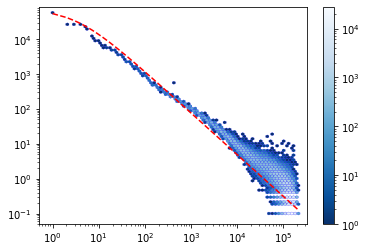

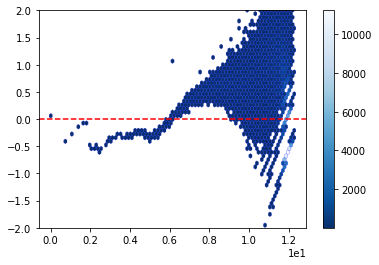

In [63]:
real_plot_2 = plot_zipf(fano_real_2)

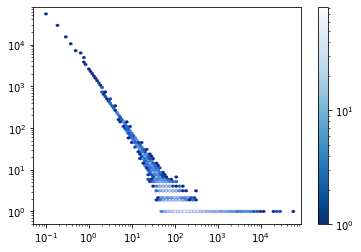

In [65]:
freq_of_freqs_hexbin_plot(real_plot_2['Frequency'])

In [68]:
real_plot_2.to_pickle('df_real_2.pkl')

### 3

In [72]:
rank_sents_real_3, freq_sents_real_3, sen_len_real_3 = subsampling(real_pos_3)

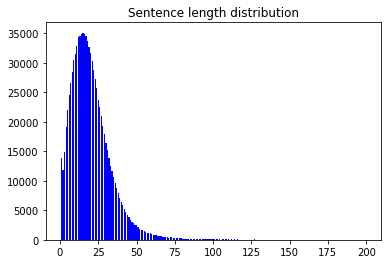

In [73]:
plt.bar(list(sen_len_real_3.keys()), sen_len_real_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [74]:
ranks_freqs_real_3 = ranks_freqs(rank_sents_real_3, freq_sents_real_3)

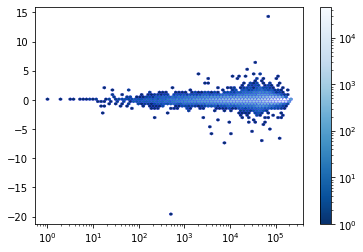

In [75]:
fano_real_3 = fano_factor(ranks_freqs_real_3)

In [69]:
fano_3 = pickle.load(open('df_real_3.pkl', 'rb'))

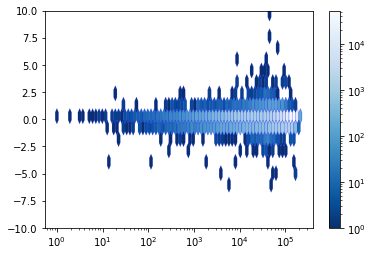

In [70]:
fano_plot(fano_2, ylim = [-10,10])

Optimization terminated successfully.
         Current function value: 19.446316
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


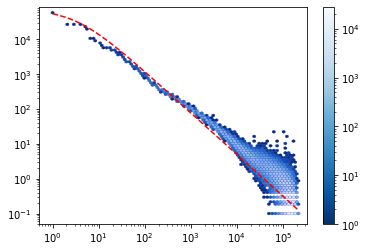

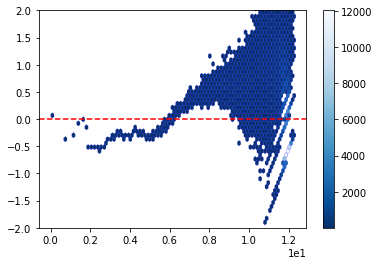

In [76]:
real_plot_3 = plot_zipf(fano_real_3)

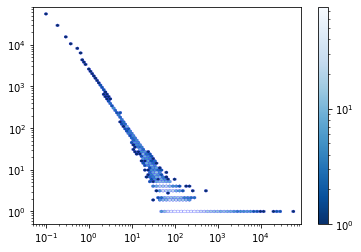

In [77]:
freq_of_freqs_hexbin_plot(real_plot_3['Frequency'])

In [78]:
real_plot_3.to_pickle('df_real_3.pkl')

### 4

In [106]:
rank_sents_real_4, freq_sents_real_4, sen_len_real_4 = subsampling(real_pos_4)

In [107]:
pickle.dump(sen_len_real_4, open("sen_len_real_4.p", "wb"))

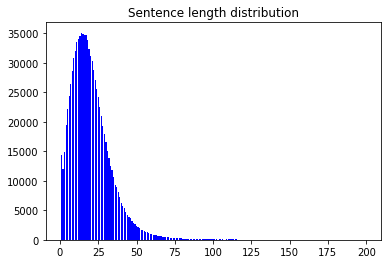

In [108]:
plt.bar(list(sen_len_real_4.keys()), sen_len_real_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [109]:
ranks_freqs_real_4 = ranks_freqs(rank_sents_real_4, freq_sents_real_4)

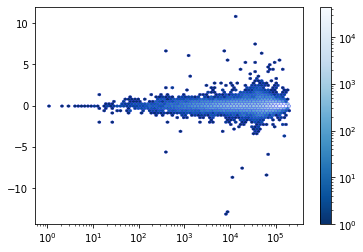

In [110]:
fano_real_4 = fano_factor(ranks_freqs_real_4)

Optimization terminated successfully.
         Current function value: 19.456186
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


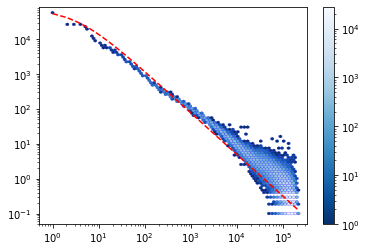

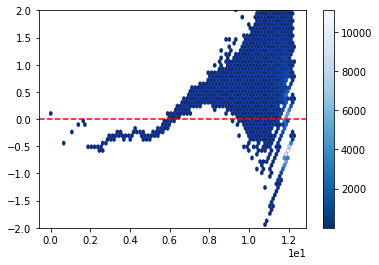

In [111]:
real_plot_4 = plot_zipf(fano_real_4)

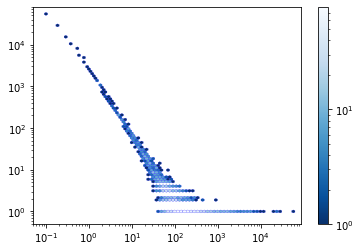

In [112]:
freq_of_freqs_hexbin_plot(real_plot_4['Frequency'])

In [113]:
real_plot_4.to_pickle('df_real_4.pkl')

### 5

In [34]:
rank_sents_real_5, freq_sents_real_5, sen_len_real_5 = subsampling(real_pos_5)

In [35]:
pickle.dump(sen_len_real_5, open("sen_len_real_5.p", "wb"))

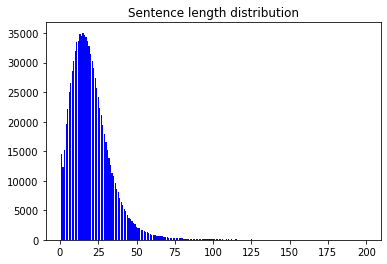

In [36]:
plt.bar(list(sen_len_real_5.keys()), sen_len_real_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [37]:
ranks_freqs_real_5 = ranks_freqs(rank_sents_real_5, freq_sents_real_5)

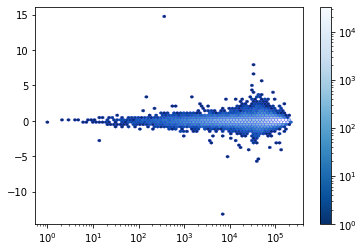

In [38]:
fano_real_5 = fano_factor(ranks_freqs_real_5)

Optimization terminated successfully.
         Current function value: 19.357884
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.17)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


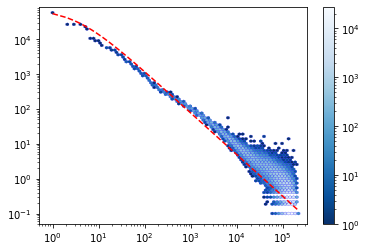

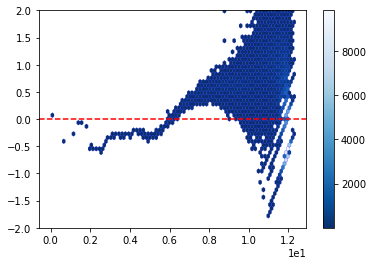

In [39]:
real_plot_5 = plot_zipf(ranks_freqs_real_5)

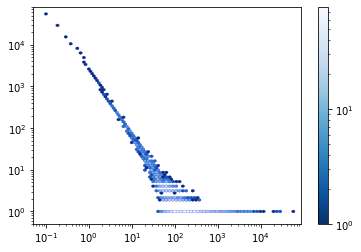

In [40]:
freq_of_freqs_hexbin_plot(real_plot_5['Frequency'])

# Tests generated text

### 1

In [79]:
rank_sents_k40_1, freq_sents_k40_1, sen_len_k40_1 = subsampling(gpt_small_k40_pos_1)

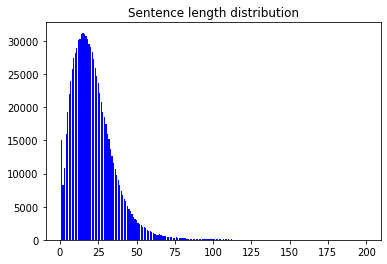

In [80]:
plt.bar(list(sen_len_k40_1.keys()), sen_len_k40_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [81]:
ranks_freqs_k40_1 = ranks_freqs(rank_sents_k40_1, freq_sents_k40_1)

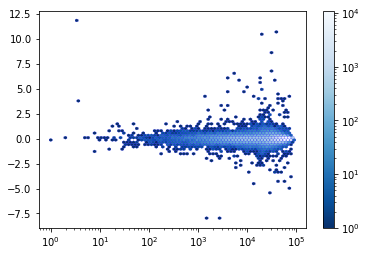

In [82]:
fano_k40_1 = fano_factor(ranks_freqs_k40_1)

Optimization terminated successfully.
         Current function value: 39.881365
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.42)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00565)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


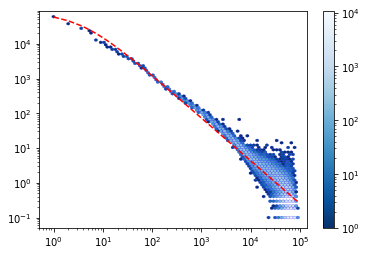

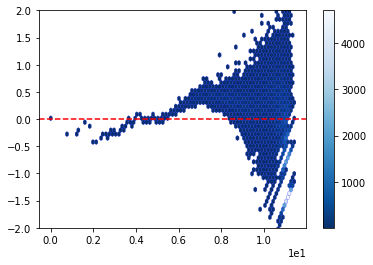

In [83]:
gpt_small_k40_1_plot = plot_zipf(fano_k40_1)

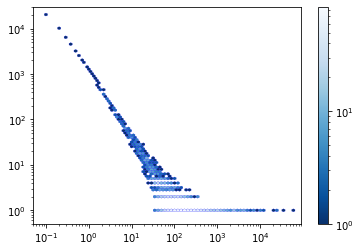

In [84]:
freq_of_freqs_hexbin_plot(gpt_small_k40_1_plot['Frequency'])

In [85]:
gpt_small_k40_1_plot.to_pickle('df_k40_1.pkl')

### 2

In [86]:
rank_sents_k40_2, freq_sents_k40_2, sen_len_k40_2 = subsampling(gpt_small_k40_pos_2)

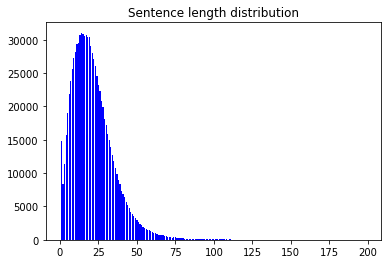

In [87]:
plt.bar(list(sen_len_k40_2.keys()), sen_len_k40_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [88]:
ranks_freqs_k40_2 = ranks_freqs(rank_sents_k40_2, freq_sents_k40_2)

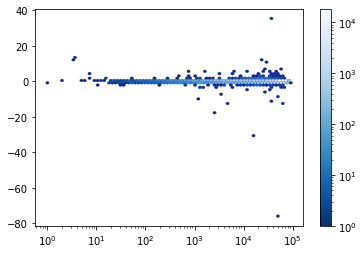

In [89]:
fano_k40_2 = fano_factor(ranks_freqs_k40_2)

Optimization terminated successfully.
         Current function value: 40.147515
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.42)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


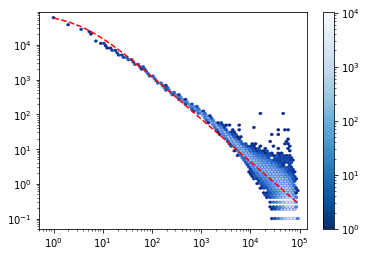

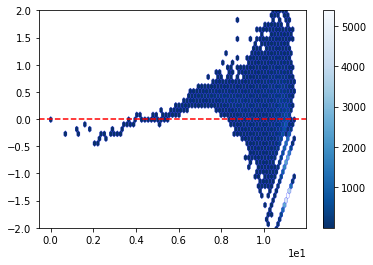

In [90]:
gpt_small_k40_2_plot = plot_zipf(fano_k40_2)

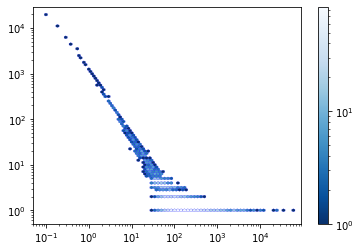

In [91]:
freq_of_freqs_hexbin_plot(gpt_small_k40_2_plot['Frequency'])

In [92]:
gpt_small_k40_2_plot.to_pickle('df_k40_2.pkl')

### 3

In [93]:
rank_sents_k40_3, freq_sents_k40_3, sen_len_k40_3 = subsampling(gpt_small_k40_pos_3)

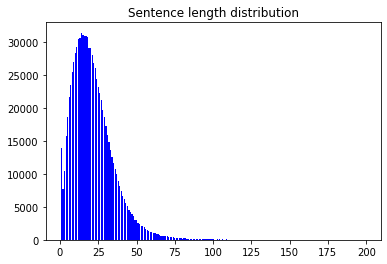

In [94]:
plt.bar(list(sen_len_k40_3.keys()), sen_len_k40_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [95]:
ranks_freqs_k40_3 = ranks_freqs(rank_sents_k40_3, freq_sents_k40_3)

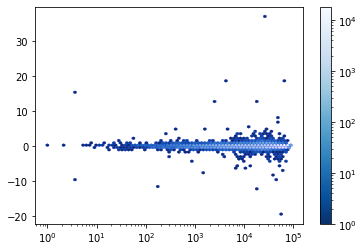

In [96]:
fano_k40_3 = fano_factor(ranks_freqs_k40_3)

Optimization terminated successfully.
         Current function value: 39.960822
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.43)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


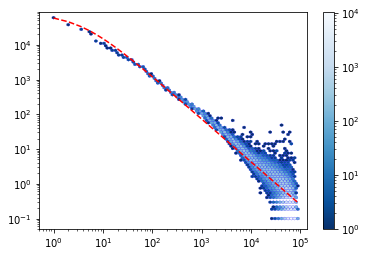

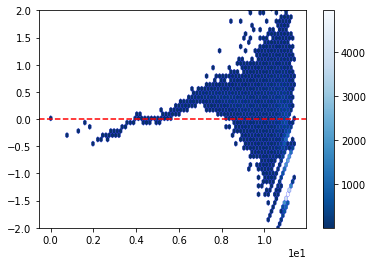

In [97]:
gpt_small_k40_3_plot = plot_zipf(fano_k40_3)

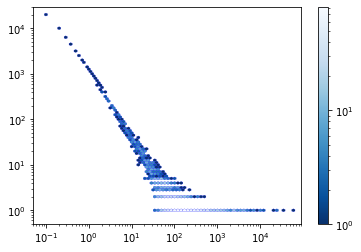

In [98]:
freq_of_freqs_hexbin_plot(gpt_small_k40_3_plot['Frequency'])

In [99]:
gpt_small_k40_3_plot.to_pickle('df_k40_3.pkl')

### 4

In [26]:
rank_sents_k40_4, freq_sents_k40_4, sen_len_k40_4 = subsampling(gpt_small_k40_pos_4)

In [27]:
pickle.dump(sen_len_k40_4, open("sen_len_k40_4.p", "wb"))

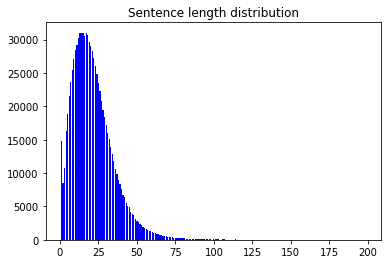

In [28]:
plt.bar(list(sen_len_k40_4.keys()), sen_len_k40_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [29]:
ranks_freqs_k40_4 = ranks_freqs(rank_sents_k40_4, freq_sents_k40_4)

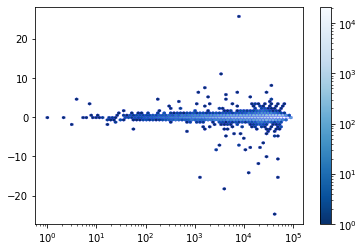

In [30]:
fano_k40_4 = fano_factor(ranks_freqs_k40_4)

Optimization terminated successfully.
         Current function value: 39.923858
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.43)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6170000.0, [3.88]


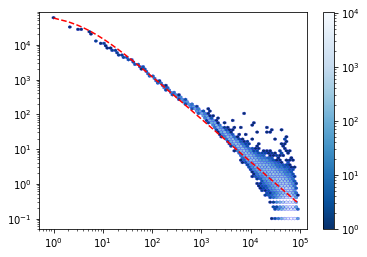

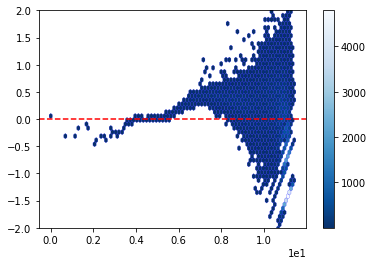

In [31]:
gpt_small_k40_4_plot = plot_zipf(fano_k40_4)

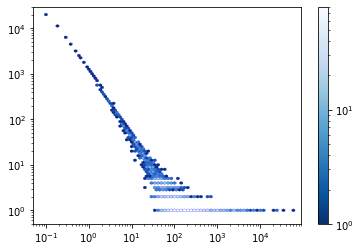

In [32]:
freq_of_freqs_hexbin_plot(gpt_small_k40_4_plot['Frequency'])

In [33]:
gpt_small_k40_4_plot.to_pickle('df_k40_4.pkl')

### 5

In [51]:
rank_sents_k40_5, freq_sents_k40_5, sen_len_k40_5 = subsampling(k40_5)

In [52]:
pickle.dump(sen_len_k40_5, open("sen_len_k40_5.p", "wb"))

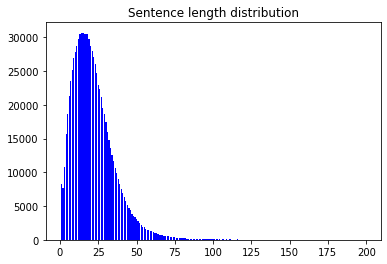

In [53]:
plt.bar(list(sen_len_k40_5.keys()), sen_len_k40_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [54]:
ranks_freqs_k40_5 = ranks_freqs(rank_sents_k40_5, freq_sents_k40_5)

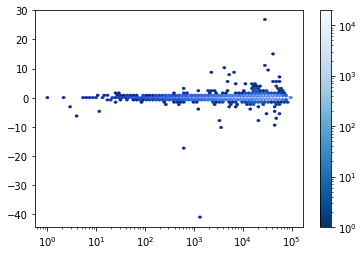

In [55]:
fano_k40_5 = fano_factor(ranks_freqs_k40_5)

Optimization terminated successfully.
         Current function value: 40.827385
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.24, 3.55)
  Standard Error [relative]: (0.000427, 0.0193), [(0.000345, 0.00543)]
  Pseudo R^2: 0.746
  BIC [relative]: 6040000.0, [3.94]


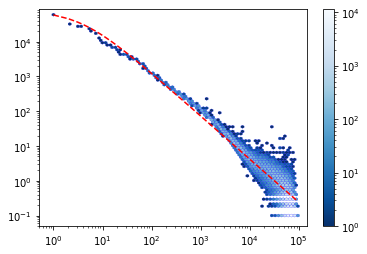

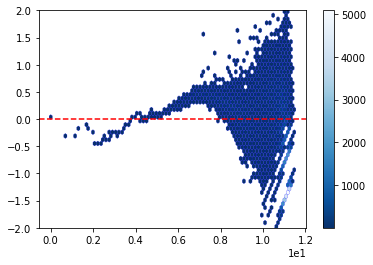

In [56]:
gpt_small_k40_5_plot = plot_zipf(fano_k40_5)

In [57]:
gpt_small_k40_5_plot.to_pickle('df_k40_5.pkl')

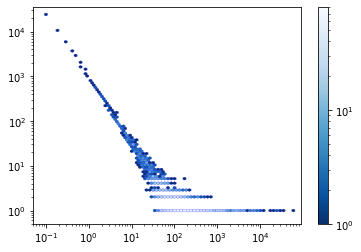

In [71]:
freq_of_freqs_hexbin_plot(gpt_small_k40_5_plot['Frequency'])

# Tets files

## Real

### 1

In [184]:
rank_sents_real_test_1, freq_sents_real_test_1, sen_len_real_test_1 = subsampling(real_test_1, k=10000)

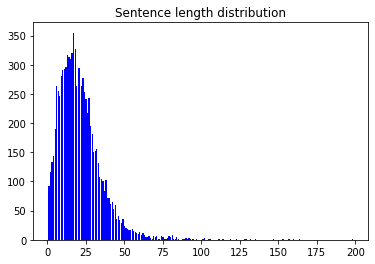

In [185]:
plt.bar(list(sen_len_real_test_1.keys()), sen_len_real_test_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [186]:
ranks_freqs_real_test_1 = ranks_freqs(rank_sents_real_test_1, freq_sents_real_test_1)

In [187]:
fano_real_test_1 = fano_factor(ranks_freqs_real_test_1)

In [188]:
real_test_plot_1 = plot_zipf(fano_real_test_1)

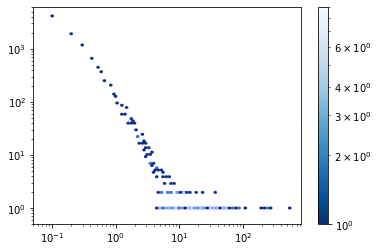

In [189]:
freq_of_freqs_hexbin_plot(real_test_plot_1['Frequency'])

### 2

In [316]:
rank_sents_real_test_2, freq_sents_real_test_2, sen_len_real_test_2 = subsampling(real_test_2, k=10000)

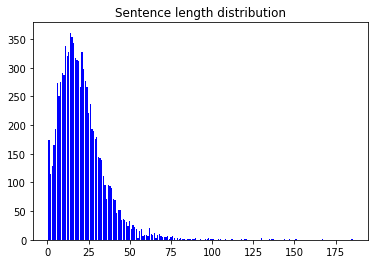

In [317]:
plt.bar(list(sen_len_real_test_2.keys()), sen_len_real_test_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [318]:
ranks_freqs_real_test_2 = ranks_freqs(rank_sents_real_test_2, freq_sents_real_test_2)

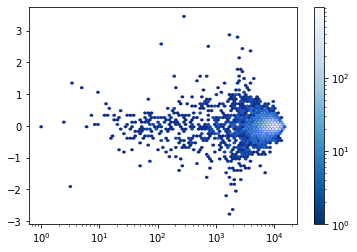

In [319]:
fano_real_test_2 = fano_factor(ranks_freqs_real_test_2)

Optimization terminated successfully.
         Current function value: 2.889556
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.19, 1.81)
  Standard Error [relative]: (0.00329, 0.0762), [(0.00276, 0.0421)]
  Pseudo R^2: 0.713
  BIC [relative]: 63600.0, [3.49]


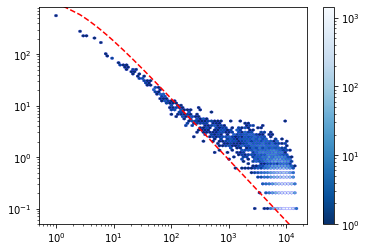

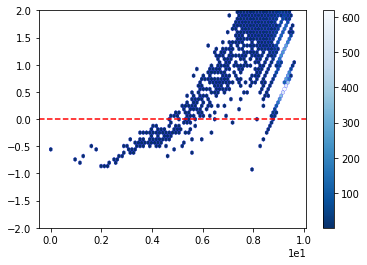

In [320]:
real_test_plot_2 = plot_zipf(fano_real_test_2)

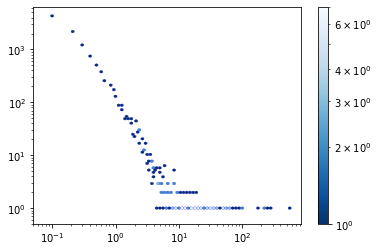

In [321]:
freq_of_freqs_hexbin_plot(real_test_plot_2['Frequency'])

### 3

In [322]:
rank_sents_real_test_3, freq_sents_real_test_3, sen_len_real_test_3 = subsampling(real_test_3, k=10000)

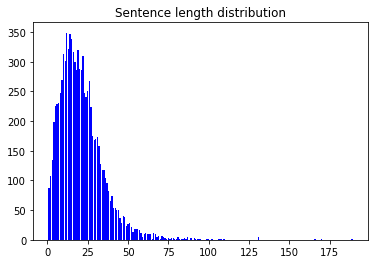

In [323]:
plt.bar(list(sen_len_real_test_3.keys()), sen_len_real_test_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [324]:
ranks_freqs_real_test_3 = ranks_freqs(rank_sents_real_test_3, freq_sents_real_test_3)

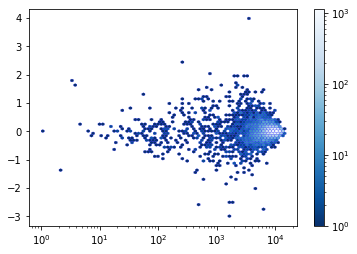

In [325]:
fano_real_test_3 = fano_factor(ranks_freqs_real_test_3)

Optimization terminated successfully.
         Current function value: 2.944900
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.2, 1.8)
  Standard Error [relative]: (0.00334, 0.0765), [(0.00279, 0.0424)]
  Pseudo R^2: 0.715
  BIC [relative]: 62800.0, [3.51]


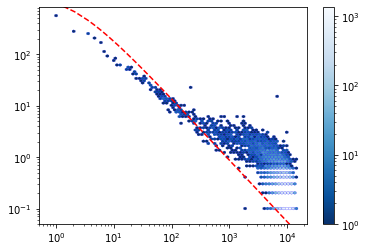

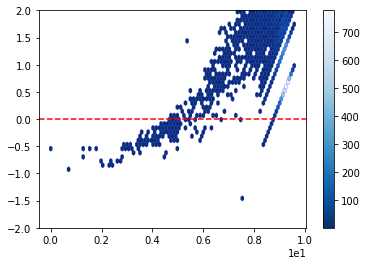

In [326]:
real_test_plot_3 = plot_zipf(fano_real_test_3)

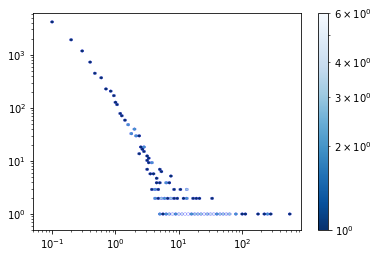

In [327]:
freq_of_freqs_hexbin_plot(real_test_plot_3['Frequency'])

### 4

In [328]:
rank_sents_real_test_4, freq_sents_real_test_4, sen_len_real_test_4 = subsampling(real_test_4, k=10000)

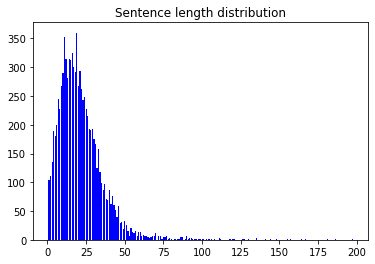

In [329]:
plt.bar(list(sen_len_real_test_4.keys()), sen_len_real_test_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [330]:
ranks_freqs_real_test_4 = ranks_freqs(rank_sents_real_test_4, freq_sents_real_test_4)

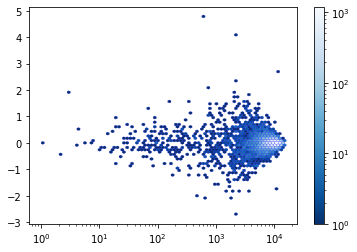

In [331]:
fano_real_test_4 = fano_factor(ranks_freqs_real_test_4)

Optimization terminated successfully.
         Current function value: 2.914029
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.19, 1.8)
  Standard Error [relative]: (0.0033, 0.0765), [(0.00276, 0.0424)]
  Pseudo R^2: 0.713
  BIC [relative]: 63500.0, [3.49]


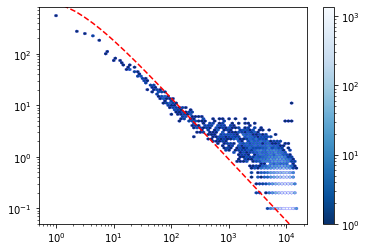

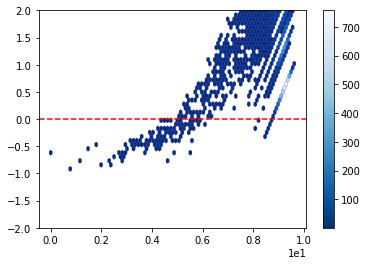

In [332]:
real_test_plot_4 = plot_zipf(fano_real_test_4)

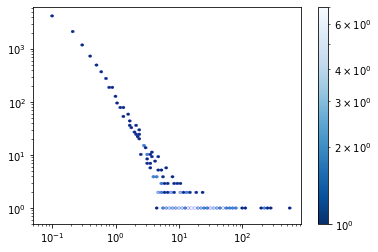

In [333]:
freq_of_freqs_hexbin_plot(real_test_plot_4['Frequency'])

### 5

In [334]:
rank_sents_real_test_5, freq_sents_real_test_5, sen_len_real_test_5 = subsampling(real_test_5, k=10000)

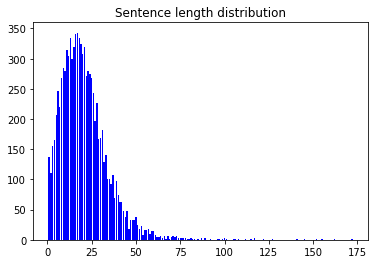

In [335]:
plt.bar(list(sen_len_real_test_5.keys()), sen_len_real_test_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [336]:
ranks_freqs_real_test_5 = ranks_freqs(rank_sents_real_test_5, freq_sents_real_test_5)

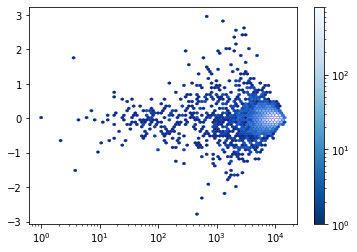

In [337]:
fano_real_test_5 = fano_factor(ranks_freqs_real_test_5)

Optimization terminated successfully.
         Current function value: 2.983701
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.2, 1.82)
  Standard Error [relative]: (0.00335, 0.0756), [(0.0028, 0.0415)]
  Pseudo R^2: 0.716
  BIC [relative]: 62600.0, [3.52]


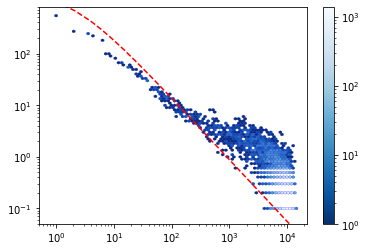

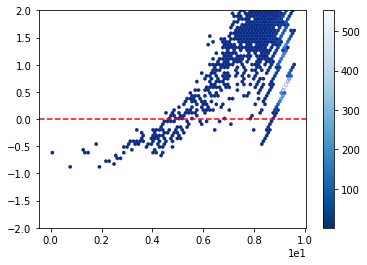

In [338]:
real_test_plot_5 = plot_zipf(fano_real_test_5)

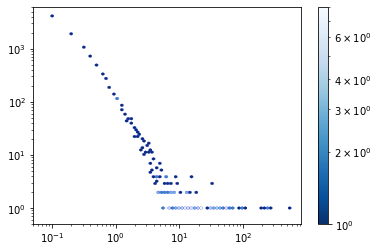

In [339]:
freq_of_freqs_hexbin_plot(real_test_plot_5['Frequency'])

## GPT

### 1

In [340]:
rank_sents_k40_test_1, freq_sents_k40_test_1, sen_len_k40_test_1 = subsampling(k40_test_1, k=10000)

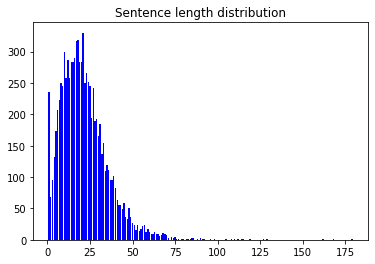

In [341]:
plt.bar(list(sen_len_k40_test_1.keys()), sen_len_k40_test_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [342]:
ranks_freqs_k40_test_1 = ranks_freqs(rank_sents_k40_test_1, freq_sents_k40_test_1)

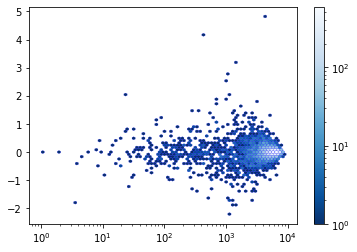

In [343]:
fano_k40_test_1 = fano_factor(ranks_freqs_k40_test_1)

Optimization terminated successfully.
         Current function value: 4.364083
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.94)
  Standard Error [relative]: (0.00378, 0.0696), [(0.00308, 0.0358)]
  Pseudo R^2: 0.738
  BIC [relative]: 59300.0, [3.82]


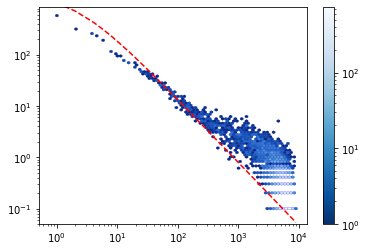

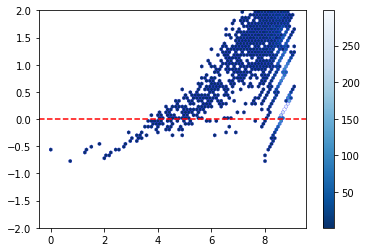

In [344]:
k40_test_plot_1 = plot_zipf(fano_k40_test_1)

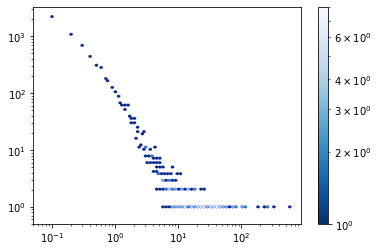

In [345]:
freq_of_freqs_hexbin_plot(k40_test_plot_1['Frequency'])

### 2

In [346]:
rank_sents_k40_test_2, freq_sents_k40_test_2, sen_len_k40_test_2 = subsampling(k40_test_2, k=10000)

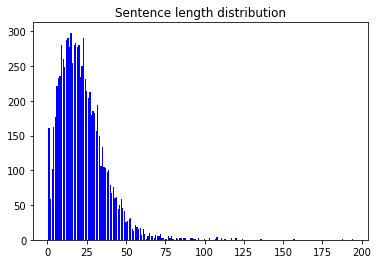

In [347]:
plt.bar(list(sen_len_k40_test_2.keys()), sen_len_k40_test_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [348]:
ranks_freqs_k40_test_2 = ranks_freqs(rank_sents_k40_test_2, freq_sents_k40_test_2)

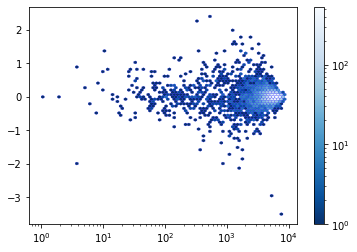

In [349]:
fano_k40_test_2 = fano_factor(ranks_freqs_k40_test_2)

Optimization terminated successfully.
         Current function value: 4.382054
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.98)
  Standard Error [relative]: (0.00378, 0.0683), [(0.00308, 0.0346)]
  Pseudo R^2: 0.739
  BIC [relative]: 59300.0, [3.83]


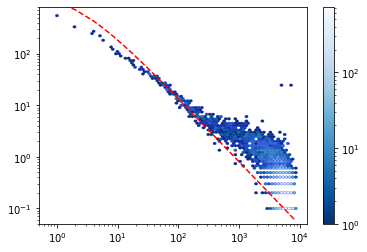

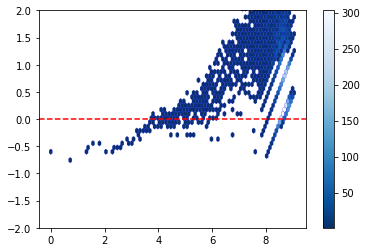

In [350]:
k40_test_plot_2 = plot_zipf(fano_k40_test_2)

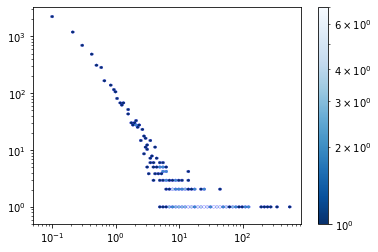

In [351]:
freq_of_freqs_hexbin_plot(k40_test_plot_2['Frequency'])

### 3

In [352]:
rank_sents_k40_test_3, freq_sents_k40_test_3, sen_len_k40_test_3 = subsampling(k40_test_3, k=10000)

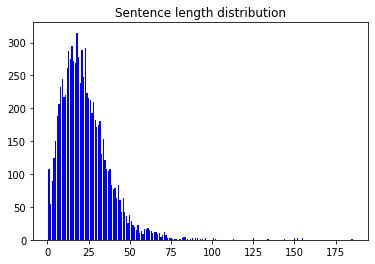

In [353]:
plt.bar(list(sen_len_k40_test_3.keys()), sen_len_k40_test_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [354]:
ranks_freqs_k40_test_3 = ranks_freqs(rank_sents_k40_test_3, freq_sents_k40_test_3)

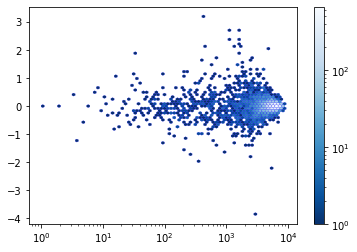

In [355]:
fano_k40_test_3 = fano_factor(ranks_freqs_k40_test_3)

Optimization terminated successfully.
         Current function value: 4.278127
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.93)
  Standard Error [relative]: (0.00375, 0.07), [(0.00306, 0.0362)]
  Pseudo R^2: 0.737
  BIC [relative]: 59800.0, [3.81]


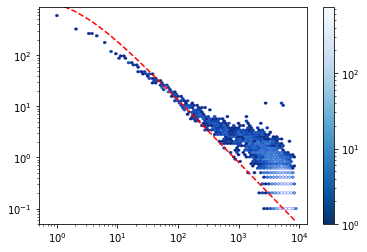

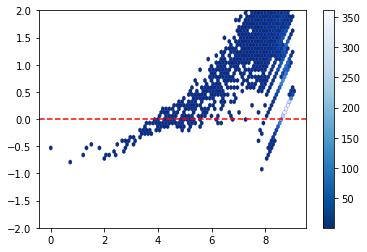

In [356]:
k40_test_plot_3 = plot_zipf(fano_k40_test_3)

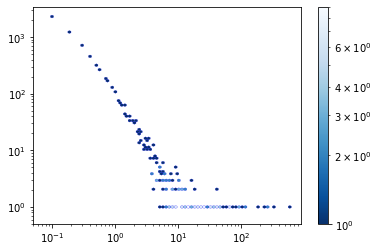

In [357]:
freq_of_freqs_hexbin_plot(k40_test_plot_3['Frequency'])

### 4

In [358]:
rank_sents_k40_test_4, freq_sents_k40_test_4, sen_len_k40_test_4 = subsampling(k40_test_4, k=10000)

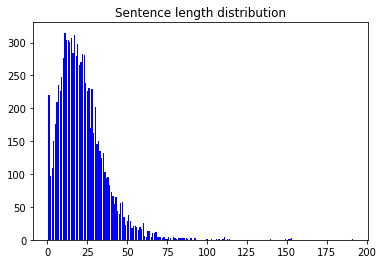

In [359]:
plt.bar(list(sen_len_k40_test_4.keys()), sen_len_k40_test_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [360]:
ranks_freqs_k40_test_4 = ranks_freqs(rank_sents_k40_test_4, freq_sents_k40_test_4)

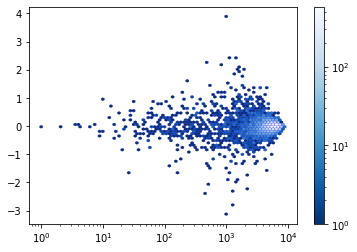

In [361]:
fano_k40_test_4 = fano_factor(ranks_freqs_k40_test_4)

Optimization terminated successfully.
         Current function value: 4.389129
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.96)
  Standard Error [relative]: (0.0038, 0.0691), [(0.00309, 0.0353)]
  Pseudo R^2: 0.74
  BIC [relative]: 59300.0, [3.84]


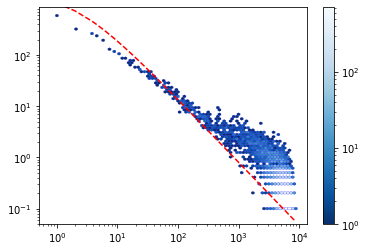

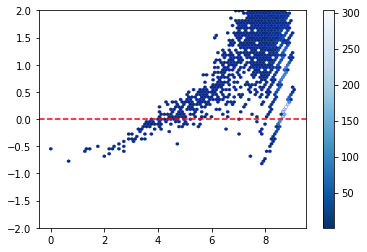

In [362]:
k40_test_plot_4 = plot_zipf(fano_k40_test_4)

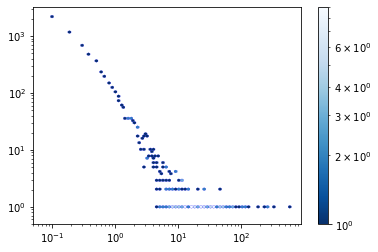

In [363]:
freq_of_freqs_hexbin_plot(k40_test_plot_4['Frequency'])

### 5

In [364]:
rank_sents_k40_test_5, freq_sents_k40_test_5, sen_len_k40_test_5 = subsampling(k40_test_5, k=10000)

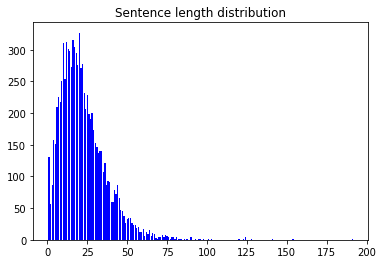

In [365]:
plt.bar(list(sen_len_k40_test_5.keys()), sen_len_k40_test_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [366]:
ranks_freqs_k40_test_5 = ranks_freqs(rank_sents_k40_test_5, freq_sents_k40_test_5)

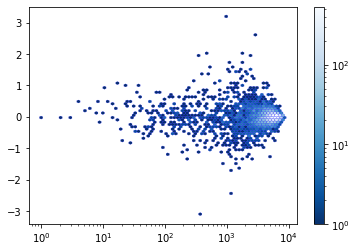

In [367]:
fano_k40_test_5 = fano_factor(ranks_freqs_k40_test_5)

Optimization terminated successfully.
         Current function value: 4.461878
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.23, 1.95)
  Standard Error [relative]: (0.00383, 0.0693), [(0.00311, 0.0355)]
  Pseudo R^2: 0.741
  BIC [relative]: 58700.0, [3.86]


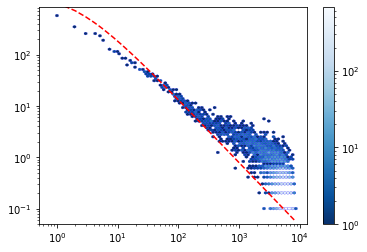

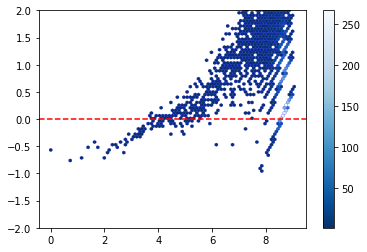

In [368]:
k40_test_plot_5 = plot_zipf(fano_k40_test_5)

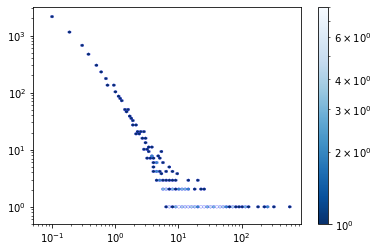

In [369]:
freq_of_freqs_hexbin_plot(k40_test_plot_5['Frequency'])

In [372]:
real_test_plot_1['Round'] = round(real_test_plot_1['Rank']).astype(int)

In [373]:
k40_test_plot_1['Round'] = round(k40_test_plot_1['Rank']).astype(int)

In [379]:
real_test_plot_1['Ding'] = real_test_plot_1['Rank'] * real_test_plot_1['Frequency']

In [385]:
real_test_plot_1

,,0,1,2,3,4,5,6,7,8,9,...,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error,Round,Ding
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,583.0,561.6,0.000000,1012.717920,0.000000,6.330790,6.920393,-0.589603,1,561.60
to,TO,2.0,2.0,2.0,3.0,2.0,4.0,4.0,2.0,3.0,2.0,...,276.0,278.8,0.649573,589.767864,0.955511,5.630495,6.379729,-0.749234,3,724.88
of,IN,4.0,4.0,4.0,2.0,4.0,2.0,2.0,4.0,4.0,3.0,...,258.0,248.5,-0.353535,494.277574,1.193922,5.515443,6.203097,-0.687654,3,820.05
and,CC,3.0,3.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,4.0,...,239.0,240.8,0.287582,482.926546,1.223775,5.483967,6.179865,-0.695898,3,818.72
a,DT,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,223.0,221.7,0.877069,369.766786,1.547563,5.401325,5.912872,-0.511547,5,1041.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
midwife,NN,17429.0,12604.0,16154.0,18742.0,7300.0,18927.0,19030.0,2427.0,18987.0,12276.0,...,0.0,0.1,0.035852,0.036654,9.574122,-2.302585,-3.306246,1.003661,14388,1438.76
detector,NN,18615.0,1563.0,15951.0,13341.0,18652.0,18509.0,11540.0,9293.0,17486.0,19043.0,...,0.0,0.1,-0.008166,0.036618,9.574935,-2.302585,-3.307219,1.004634,14399,1439.93
entourages,NNS,15750.0,18850.0,17727.0,16840.0,15178.0,3700.0,17284.0,4090.0,17818.0,17093.0,...,0.0,0.1,0.010139,0.036516,9.577273,-2.302585,-3.310017,1.007432,14433,1443.30
speeds,NNS,18110.0,17218.0,17996.0,4983.0,18847.0,17790.0,18979.0,16164.0,1948.0,15052.0,...,0.0,0.2,0.057952,0.035698,9.596194,-1.609438,-3.332663,1.723225,14709,2941.74


In [388]:
real_test_plot_1.loc[real_test_plot_1['Frequency'] >= 1]

,,0,1,2,3,4,5,6,7,8,9,...,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error,Round,Ding
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,583.0,561.6,0.000000,1012.717920,0.000000,6.330790,6.920393,-0.589603,1,561.60
to,TO,2.0,2.0,2.0,3.0,2.0,4.0,4.0,2.0,3.0,2.0,...,276.0,278.8,0.649573,589.767864,0.955511,5.630495,6.379729,-0.749234,3,724.88
of,IN,4.0,4.0,4.0,2.0,4.0,2.0,2.0,4.0,4.0,3.0,...,258.0,248.5,-0.353535,494.277574,1.193922,5.515443,6.203097,-0.687654,3,820.05
and,CC,3.0,3.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,4.0,...,239.0,240.8,0.287582,482.926546,1.223775,5.483967,6.179865,-0.695898,3,818.72
a,DT,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,223.0,221.7,0.877069,369.766786,1.547563,5.401325,5.912872,-0.511547,5,1041.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fiscal,JJ,17557.0,15514.0,15528.0,14823.0,2906.0,15338.0,1333.0,15592.0,8579.0,637.0,...,0.0,1.1,0.111220,0.051775,9.285513,0.095310,-2.960842,3.056153,10781,11858.77
bank,NN,3916.0,18753.0,5360.0,14218.0,12612.0,10126.0,11581.0,12413.0,15020.0,3885.0,...,1.0,1.1,0.070318,0.051731,9.286227,0.095310,-2.961697,3.057007,10788,11867.24
restaurant,NN,17956.0,1342.0,3840.0,17288.0,13968.0,16245.0,2002.0,17739.0,10684.0,10287.0,...,3.0,1.5,0.156497,0.049809,9.317858,0.405465,-2.999551,3.405017,11135,16702.65
walker,NNP,2318.0,16667.0,12901.0,18182.0,1681.0,6335.0,8962.0,15923.0,15399.0,13179.0,...,1.0,1.2,0.407766,0.049705,9.319616,0.182322,-3.001656,3.183978,11155,13385.64


In [389]:
np.mean(real_test_plot_1['Frequency'])

0.8414583529855675

In [391]:
np.mean(real_test_plot_2['Frequency'])

0.8142974004726411

In [392]:
np.mean(real_test_plot_3['Frequency'])

0.8371683075480545

In [393]:
np.mean(real_test_plot_4['Frequency'])

0.8223211826278578

In [394]:
np.mean(real_test_plot_5['Frequency'])

0.851795751167

In [390]:
np.mean(k40_test_plot_1['Frequency'])

1.3836692658525822

In [395]:
np.mean(k40_test_plot_2['Frequency'])

1.3936390532544378

In [396]:
np.mean(k40_test_plot_3['Frequency'])

1.3508227214193733

In [397]:
np.mean(k40_test_plot_4['Frequency'])

1.4005333333333332

In [398]:
np.mean(k40_test_plot_5['Frequency'])

1.4321987539887553

In [400]:
# [0.8414583529855675, 0.8142974004726411, 0.8371683075480545, 0.8223211826278578, 0.851795751167]
# [1.3836692658525822, 1.3936390532544378, 1.3508227214193733, 1.4005333333333332, 1.4321987539887553]

In [401]:
len(real_test_plot_1['Frequency'])

10601

In [402]:
len(k40_test_plot_1['Frequency'])

6797

In [404]:
real_test_plot_1['Frequency'].std(axis=0)

8.157728879827982

In [ ]:
df.std(axis = 0, skipna = True)

In [45]:
def split_corpus(corpus, n):
    random.shuffle(corpus)
    return np.array_split(corpus, n)

In [134]:
def sample_corpora(corpus1, n=10):
    random.shuffle(corpus1)
    corpus1_split = split_corpus(corpus1, n)

    corpus1_split = [[item for sublist in corpus for item in sublist] for corpus in corpus1_split]
    corpus1_split = [[item for sublist in corpus for item in sublist] for corpus in corpus1_split]

    freqs_1 = calculate_freqs(corpus1_split)

#     mean_freqs_1 = mean_freqs(freqs_1)
#     mean_freqs_2 = mean_freqs(freqs_2)
    
#     freqs_comb = pd.concat([mean_freqs_1, mean_freqs_2], axis=1, sort=False)
#     freqs_comb.set_axis(["Freqs C1", "Freqs C2"], axis=1, inplace=True)
    
    
    return freqs_1

In [153]:
def average_freqs(corpus, text, n=10, repeat = 10):
    df = pd.concat([sample_corpora(corpus, n=n) for i in range(repeat)], axis=1, sort=False)
    df2 = pd.DataFrame(index=df.index)
    for i in range(n):
        avg = df[[i]].mean(axis=1)
        df2["{} {}".format(text, i)] = avg
    df2["{} sum".format(text)] = np.sum(df2, axis = 1)
        
    return df2

In [303]:
def mann_whitney_df(corpus1, corpus2, n=10, repeat = 10, t=30):
    avg_corpus1 = average_freqs(corpus1, text="C1", n=n, repeat = repeat)
    avg_corpus2 = average_freqs(corpus2, text="C2", n=n, repeat = repeat)
    df = pd.concat([avg_corpus1, avg_corpus2], axis=1)
    df = df.fillna(0)
    df["tot sum"] = np.sum(df, axis = 1)
    df = df.loc[(df["C1 sum"] >= t) | (df["C2 sum"] >= 30)]
#     df = df.loc[(df["C1 sum"] >= t) & (df["C2 sum"] >= 30)]
#     df = df.loc[df["tot sum"] >= t]
    return df

In [318]:
def mann_whitney_test(corpus1, corpus2, n=10, repeat = 10, t=30):
    df = mann_whitney_df(corpus1, corpus2, n=n, repeat = repeat, t=t)
    mannwhitneyu([1,2,3],[1,2,3])[1]
    stats = []
    p = []
    
    for index, row in df.iterrows():
        mann = mannwhitneyu(row[0:n], row[n+1:-3])
        stats.append(mann[0])
        p.append(mann[1])
    df['statistics'] = stats
    df['p-value'] = p
    df = df.sort_values(by=['tot sum'], ascending=False)
    df["H0"] = df['p-value'] > 0.05
    return df

In [319]:
df1 = mann_whitney_test(web_train_pos, gpt_train_pos_1, repeat = 5)

In [328]:
df1_1 = mann_whitney_test(web_train_pos_2, gpt_train_pos_1, repeat = 5)

In [329]:
df1_2 = mann_whitney_test(web_train_pos, gpt_train_pos_2, repeat = 5)

In [320]:
df2 = mann_whitney_test(web_train_pos, web_train_pos_2, repeat = 5)

In [321]:
df3 = mann_whitney_test(gpt_train_pos_1, gpt_train_pos_2, repeat = 5)

In [322]:
print("Total words: ", len(df1))
print("No H0: ", len(df1.loc[df1['p-value']<=0.05]))
print("Percentage: ", len(df1.loc[df1['p-value']<=0.05])/len(df1)*100)

Total words:  3116
No H0:  2199
Percentage:  70.57124518613607


In [332]:
print("Total words: ", len(df1_1))
print("No H0: ", len(df1_1.loc[df1_1['p-value']<=0.05]))
print("Percentage: ", len(df1_1.loc[df1_1['p-value']<=0.05])/len(df1_1)*100)

Total words:  3120
No H0:  2205
Percentage:  70.67307692307693


In [334]:
print("Total words: ", len(df1_2))
print("No H0: ", len(df1_2.loc[df1_2['p-value']<=0.05]))
print("Percentage: ", len(df1_2.loc[df1_2['p-value']<=0.05])/len(df1_2)*100)

Total words:  3126
No H0:  2217
Percentage:  70.92130518234165


In [323]:
print("Total words: ", len(df2))
print("No H0: ", len(df2.loc[df2['p-value']<=0.05]))
print("Percentage: ", len(df2.loc[df2['p-value']<=0.05])/len(df2)*100)

Total words:  3164
No H0:  1480
Percentage:  46.77623261694058


In [324]:
print("Total words: ", len(df3))
print("No H0: ", len(df3.loc[df3['p-value']<=0.05]))
print("Percentage: ", len(df3.loc[df3['p-value']<=0.05])/len(df3)*100)

Total words:  2746
No H0:  1291
Percentage:  40.80278128950695


In [377]:
df1[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,41303.0,45403.0,0.000139,False
to,TO,20601.0,27020.0,0.000140,False
of,IN,19340.0,21235.0,0.000140,False
and,CC,18978.0,19961.0,0.000190,False
a,DT,16998.0,21487.0,0.000140,False
in,IN,13802.0,15217.0,0.000140,False
is,VBZ,8622.0,10421.0,0.000140,False
it,PRP,6868.0,11218.0,0.000140,False
i,PRP,4909.0,11079.0,0.000140,False
for,IN,7075.0,7969.0,0.000139,False


In [374]:
df1_1[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,41552.0,45403.0,0.000140,False
to,TO,19694.0,27020.0,0.000140,False
of,IN,19553.0,21235.0,0.000139,False
a,DT,17111.0,21487.0,0.000140,False
and,CC,18401.0,19961.0,0.000140,False
in,IN,13913.0,15217.0,0.000191,False
is,VBZ,8311.0,10421.0,0.000139,False
it,PRP,6737.0,11218.0,0.000139,False
i,PRP,4746.0,11079.0,0.000140,False
for,IN,6908.0,7969.0,0.000140,False


In [375]:
df1_2[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,41303.0,45616.0,0.000140,False
to,TO,20601.0,26727.0,0.000139,False
of,IN,19340.0,21987.0,0.000140,False
and,CC,18978.0,19792.0,0.001874,False
a,DT,16998.0,21062.0,0.000140,False
in,IN,13802.0,15038.0,0.000140,False
is,VBZ,8622.0,10162.0,0.000140,False
it,PRP,6868.0,10192.0,0.000140,False
for,IN,7075.0,8248.0,0.000140,False
i,PRP,4909.0,10254.0,0.000140,False


In [376]:
df2[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,41303.0,41552.0,0.173767,True
to,TO,20601.0,19694.0,0.000260,False
of,IN,19340.0,19553.0,0.076521,True
and,CC,18978.0,18401.0,0.005056,False
a,DT,16998.0,17111.0,0.243834,True
in,IN,13802.0,13913.0,0.326618,True
is,VBZ,8622.0,8311.0,0.008005,False
for,IN,7075.0,6908.0,0.012372,False
it,PRP,6868.0,6737.0,0.153611,True
on,IN,5309.0,5751.0,0.000190,False


In [327]:
df3[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,45403.0,45616.0,0.483718,True
to,TO,27020.0,26727.0,0.153717,True
of,IN,21235.0,21987.0,0.015243,False
a,DT,21487.0,21062.0,0.005056,False
and,CC,19961.0,19792.0,0.102834,True
in,IN,15217.0,15038.0,0.195634,True
it,PRP,11218.0,10192.0,0.000191,False
i,PRP,11079.0,10254.0,0.002424,False
is,VBZ,10421.0,10162.0,0.018668,False
you,PRP,10306.0,9388.0,0.000630,False


In [230]:
len(df3.loc[df3['p-value']<=0.05])

0

In [361]:
def t_test(df1, df2, var):
    # Computing sample standard deviation for sample1
    SD1 = df1[var].std(axis=0)

    # Computing sample standard deviation for sample2
    SD2 = df2[var].std(axis=0)

    # calculate length of 1st sample
    n1 = len(df1[var])

    # calculate length of 2nd sample
    n2 = len(df2[var])

    pooled_standard_deviation = math.sqrt(
                          ((n1 - 1)*SD1 * SD1 +
                         (n2-1)*SD2 * SD2) / 
                                      (n1 + n2-2))
    
#     print("N1: ", n1)
#     print("N2: ", n2)
    return (np.mean(df1[var]) - np.mean(df2[var]))/np.sqrt(pooled_standard_deviation**2 * (1/n1 + 1/n2))
    
    

In [429]:
t_test(real_test_plot_1, k40_test_plot_1, 'Error')

28.183517772106484

In [430]:
t_test(real_test_plot_1, real_test_plot_2, 'Error')

1.036788466533116

In [431]:
t_test(real_test_plot_1, k40_test_plot_1, 'Frequency')

-3.702908542647478

In [432]:
t_test(real_test_plot_1, real_test_plot_2, 'Frequency')

0.24899877074662544

In [433]:
t_test(real_test_plot_1, df_real_1, 'Error')

140.9892302551525

In [337]:
df11 = mann_whitney_test(web_train_pos[0:10], gpt_train_pos_1[0:10], repeat = 10, t=30)

In [338]:
df22 = mann_whitney_test(web_train_pos_2[0:10], gpt_train_pos_1[0:10], repeat = 10, t=30)

In [339]:
df33 = mann_whitney_test(web_train_pos[0:10], gpt_train_pos_2[0:10], repeat = 10, t=30)

In [340]:
print("Total words: ", len(df11))
print("No H0: ", len(df11.loc[df11['p-value']<=0.05]))
print("Percentage: ", len(df11.loc[df11['p-value']<=0.05])/len(df11)*100)

Total words:  53
No H0:  50
Percentage:  94.33962264150944


In [341]:
print("Total words: ", len(df22))
print("No H0: ", len(df22.loc[df22['p-value']<=0.05]))
print("Percentage: ", len(df22.loc[df1['p-value']<=0.05])/len(df22)*100)

Total words:  56
No H0:  47
Percentage:  96.42857142857143


In [342]:
print("Total words: ", len(df33))
print("No H0: ", len(df33.loc[df33['p-value']<=0.05]))
print("Percentage: ", len(df33.loc[df33['p-value']<=0.05])/len(df33)*100)

Total words:  33
No H0:  27
Percentage:  81.81818181818183


In [343]:
df44 = mann_whitney_test(web_train_pos[0:10], web_train_pos_2[0:10], repeat = 10, t=30)

In [345]:
print("Total words: ", len(df44))
print("No H0: ", len(df44.loc[df44['p-value']<=0.05]))
print("Percentage: ", len(df44.loc[df44['p-value']<=0.05])/len(df44)*100)

Total words:  32
No H0:  21
Percentage:  65.625


In [346]:
df55 = mann_whitney_test(web_train_pos[0:10], web_train_pos_2[0:10], repeat = 10, t=30)

In [348]:
print("Total words: ", len(df55))
print("No H0: ", len(df55.loc[df55['p-value']<=0.05]))
print("Percentage: ", len(df55.loc[df55['p-value']<=0.05])/len(df55)*100)

Total words:  32
No H0:  22
Percentage:  68.75


In [349]:
df11[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,455.0,392.0,0.005040,False
to,TO,208.0,289.0,0.000139,False
of,IN,265.0,203.0,0.000950,False
and,CC,211.0,226.0,0.076341,True
a,DT,144.0,186.0,0.009982,False
in,IN,165.0,151.0,0.007982,False
it,PRP,54.0,174.0,0.000139,False
is,VBZ,100.0,117.0,0.005040,False
you,PRP,20.0,188.0,0.000139,False
i,PRP,29.0,155.0,0.000138,False


In [350]:
df22[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,550.0,392.0,0.000139,False
to,TO,222.0,289.0,0.000140,False
of,IN,242.0,203.0,0.002108,False
and,CC,174.0,226.0,0.000139,False
a,DT,188.0,186.0,0.195426,True
in,IN,165.0,151.0,0.184449,True
it,PRP,73.0,174.0,0.000138,False
is,VBZ,98.0,117.0,0.060247,True
you,PRP,7.0,188.0,0.000138,False
that,IN,69.0,112.0,0.001095,False


In [351]:
df33[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,455.0,448.0,0.483718,True
of,IN,265.0,187.0,0.001637,False
to,TO,208.0,219.0,0.297644,True
and,CC,211.0,174.0,0.032740,False
a,DT,144.0,219.0,0.000835,False
in,IN,165.0,137.0,0.018627,False
is,VBZ,100.0,159.0,0.000190,False
for,IN,89.0,98.0,0.088574,True
it,PRP,54.0,93.0,0.003071,False
this,DT,33.0,87.0,0.000139,False


In [352]:
df44[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,455.0,550.0,0.003982,False
of,IN,265.0,242.0,0.173873,True
to,TO,208.0,222.0,0.076160,True
and,CC,211.0,174.0,0.000298,False
a,DT,144.0,188.0,0.002424,False
in,IN,165.0,165.0,0.483696,True
is,VBZ,100.0,98.0,0.207006,True
for,IN,89.0,49.0,0.000139,False
was,VBD,27.0,101.0,0.000138,False
it,PRP,54.0,73.0,0.000712,False


In [353]:
df55[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

,,C1 sum,C2 sum,p-value,H0
the,DT,455.0,550.0,0.000472,False
of,IN,265.0,242.0,0.082469,True
to,TO,208.0,222.0,0.039195,False
and,CC,211.0,174.0,0.012341,False
a,DT,144.0,188.0,0.003117,False
in,IN,165.0,165.0,0.500000,True
is,VBZ,100.0,98.0,0.256444,True
for,IN,89.0,49.0,0.000190,False
was,VBD,27.0,101.0,0.000137,False
it,PRP,54.0,73.0,0.009847,False


In [354]:
def test_trial(data, x, c=5, m=10, pos=None):
    varss = ['Frequency', 'Error', 'Fano']
    t_values = [[], [], []]
    len_x = 0
    len_data = len(data)
    for sen in x:
        len_x +=len(sen)
        
    k = int(len_x/50)
    if k % 2 != 0:
        k+= 1
    
    print("Length of X: {} tokens".format(len_x))
    corpus = data
    
    
    rank_sents, freq_sents, sen_len = subsampling(x, k = k, m = m)
    ranks_freqs_df = ranks_freqs(rank_sents, freq_sents)
    fano_df = fano_factor(ranks_freqs_df)
    df1 = plot_zipf(fano_df)
    print("N1: ", len(df1))
    
    for i in range(c):
        corpus = []
        used = set()
        count = 0
        while count < len_x:
            index = np.random.randint(len_data)
            if index in used:
                continue
                    
            sample = data[index]
            len_sample = len(sample)
                    
            if len_sample == 0:
                continue
                        
            corpus.append(sample)
            count += len_sample          
            used.add(index)

                    
        rank_sents, freq_sents, sen_len = subsampling(corpus, k = k, m = m)
        ranks_freqs_df = ranks_freqs(rank_sents, freq_sents)
        fano_df = fano_factor(ranks_freqs_df)
        df2 = plot_zipf(fano_df)
        
        for i, var in enumerate(varss):
            t_values[i].append(t_test(df1, df2, var))
        
    for i, var in enumerate(varss):
        print("\n{}:\n{} \n Min: {}\n".format(var, t_values[i], min(t_values[i])))
    
    return None

In [360]:
test_trial(real_test_1, real_test_2[:1000])

Length of X: 20902 tokens
N1:  749


NameError: name 't_test' is not defined

In [362]:
test_trial(real_test_1, k40_test_2[:1000])

Length of X: 22793 tokens
N1:  719

Frequency:
[1.765057751793215, 1.5330802018952803, 1.496695895613792, 2.328221326679277, 2.167058186485792] 
 Min: 1.496695895613792


Error:
[-11.48488070234498, -10.516382322111625, -11.326543145158514, -9.803789151412081, -9.965641426847998] 
 Min: -11.48488070234498


Fano:
[0.16200977908423234, -0.12708316263161837, 0.6387835894574031, 0.008685933482800912, 1.1654090498273608] 
 Min: -0.12708316263161837



In [363]:
test_trial(real_test_1, real_test_2[:1000], c=20)

Length of X: 20902 tokens
N1:  833

Frequency:
[-0.8898734117419977, -0.8932080560572621, -0.27148657965873824, -0.6842290252695282, -0.17206582445919752, -0.7940147066748728, -0.3471184690141442, -0.6059832176668699, -0.6979077833641925, -0.3229766117692293, 0.016378602574428927, -0.5348534686418097, -0.8247504446674528, 1.0140979363819342, -0.6901320832484237, 0.41349012201941643, -0.2619666373801106, -0.5259406433048834, -0.035780072900284524, -0.36890465947117684] 
 Min: -0.8932080560572621


Error:
[-5.943162266954881, -3.4567695071444464, -5.181927443234408, -9.34734628151079, -2.7087170379593113, -5.0136946215740625, -5.9495983127456835, -4.836375574781384, -6.392903439291823, -8.478558595316725, -2.8109744661641387, -2.7813589693601655, -6.3710685606341455, -0.049289195536749895, -5.594638158403592, -0.9947571167823608, -6.530493019973257, -2.9460839867844415, -3.713138864303443, -7.2210603171062315] 
 Min: -9.34734628151079


Fano:
[1.080237452419848, -0.15424938860576484, 0.2

In [179]:
test_trial(real_test_1, k40_test_2[:1000], c=20)

Length of X: 22793 tokens
N1:  690

Frequency:
[1.8875191549196593, 1.9942504986739324, 2.048810825879919, 1.2824602154204514, 1.2697666135779042, 2.339049406484217, 2.3052175214535042, 2.139617065478955, 2.299733979232183, 2.558362969712035, 1.4952036943551887, 1.9155664574234856, 1.907752201912117, 2.707891196676376, 1.854522085658398, 1.8912545960495528, 1.5632488052760112, 2.298529741638384, 1.358670800398188, 1.8877145757229024] 
 Mean: 1.950257120297168
 Abs mean: 1.950257120297168


Error:
[-7.0140465163823515, -8.859762726242863, -6.039266869997254, -7.43873786399816, -6.545667780504268, -8.885813644196, -4.523020514270861, -8.562522624921844, -11.58017156415659, -5.085460337936067, -8.572575415199832, -7.5771275880797795, -10.024004179942594, -5.5264710376800155, -7.906573696825801, -8.064187783474713, -9.359269931747368, -8.916026671513547, -9.083780869304196, -7.059795254104259] 
 Mean: -7.83121414352392
 Abs mean: 7.83121414352392


Fano:
[-0.25382849382525546, -0.261695319

In [180]:
test_trial(real_test_1, real_test_2[:1000], c=30)

Length of X: 20902 tokens
N1:  791

Frequency:
[0.11651400958423151, -0.32366356485199627, -0.10849533927772095, -0.2982935571137964, 0.08197994162288724, -0.24811798738155078, 0.02200120263698408, 0.049531154480914795, 0.11030641865240856, -0.46632752254126986, 1.3537398916492192, -0.2243311340585402, 0.10412052647089196, -0.1817744160995562, -0.5553652210248268, 0.17973493535970314, -0.5330253601627962, -0.26068076910886223, -0.5852219771054765, 0.05471850243603504, 0.01389983084965956, -0.18088853475866196, -0.13516673660005724, -0.6575490348668067, -0.7894421358024051, 0.030289638266189276, -0.3335798968732121, -0.23014993547749896, -0.34445555585015725, 0.026408270742698945] 
 Mean: -0.14377614520677892
 Abs mean: 0.2866591000569005


Error:
[0.23947900273271097, -3.6960446356752383, -2.015650628654689, -3.4352447181700465, 0.9342405332087912, 0.8129026943602442, -2.845954466120317, -4.30069672097934, -2.810029935906583, -2.831159709287474, 5.591503833924968, -1.9290357747598368, 

In [181]:
test_trial(real_test_1, k40_test_2[:1000], c=30)

Length of X: 22793 tokens
N1:  762

Frequency:
[0.8222743641955595, 1.4511514879407703, 2.38617828053341, 1.816235879645777, 1.3678408785962453, 1.2833006029381904, 1.7094830815148556, 1.4815811290436858, 1.5747266290997775, 1.9547755326038374, 1.7002923469130593, 1.8706496175273684, 1.9803654971147246, 1.8226314059916406, 1.4597205480622164, 1.61745877004879, 1.361810774115906, 1.8474693993003497, 1.4177955122482144, 1.0721043343402485, 2.322004509867529, 1.855117797465955, 1.7224381559652429, 1.9504894830963808, 1.5335579651125513, 1.1033192717347315, 1.2321992230734333, 1.581503753915583, 0.7857002022844448, 1.6284766688078194] 
 Mean: 1.5904217701032768
 Abs mean: 1.5904217701032768


Error:
[-11.96451710537302, -12.077144591394369, 20.152050843126457, -13.572285569148836, -10.866460185425613, -13.49929332226844, -13.383409535385246, 4.945877601784747, -12.02940594172913, -10.922196991054838, -12.942943721280514, -10.827597125043866, -12.498675364804894, -12.580843903537225, -10.44

In [162]:
np.abs([-1,-3])

array([1, 3])

In [143]:
length

437442

In [144]:
length = 0
for sen in real_test_2:
    length+= len(sen)

In [145]:
length

428334

In [146]:
length = 0
for sen in k40_test_1:
    length+= len(sen)

In [147]:
length

507620

In [150]:
length = 0
for sen in k40_test_2[:1000]:
    length+= len(sen)

In [198]:
df_real_1

,,0,1,2,3,4,5,6,7,8,9,...,7,8,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,57184.0,57323.0,57569.0,57448.9,0.000000,54222.533931,0.000000,10.958651,10.900852,0.057799
to,TO,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,27596.0,27781.0,28164.0,27899.9,0.000000,41921.050494,0.693147,10.236378,10.643543,-0.407165
of,IN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,25893.0,26116.0,26006.0,26095.2,0.000000,33925.516297,1.098612,10.169507,10.431923,-0.262416
and,CC,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,25284.0,25413.0,25227.0,25389.7,0.000000,28344.426663,1.386294,10.142099,10.252186,-0.110087
a,DT,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,23636.0,23459.0,23373.0,23446.6,0.000000,24245.129017,1.609438,10.062481,10.095971,-0.033490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spectaclehis,JJ,246750.0,233432.0,235807.0,191790.0,197783.0,230486.0,52783.0,253186.0,250026.0,225388.0,...,1.0,0.0,0.0,0.1,0.021747,0.128036,12.263129,-2.302585,-2.055440,-0.247145
townsquare,NNP,195214.0,55788.0,194122.0,249554.0,220167.0,237067.0,256414.0,250449.0,247084.0,213416.0,...,0.0,0.0,0.0,0.1,-0.081862,0.127903,12.264000,-2.302585,-2.056481,-0.246104
rarecasualplay,NNP,247153.0,238557.0,242107.0,253150.0,256554.0,215709.0,178001.0,65407.0,238952.0,186647.0,...,1.0,0.0,0.0,0.1,-0.076867,0.127690,12.265396,-2.302585,-2.058151,-0.244435
unrewarding,VBG,241640.0,253525.0,224952.0,219968.0,226183.0,242416.0,209679.0,251306.0,206382.0,62014.0,...,0.0,0.0,0.0,0.1,-0.002145,0.126561,12.272827,-2.302585,-2.067034,-0.235551


In [200]:
df_real_1.loc[df_real_1['Frequency'] >= 50]

,,0,1,2,3,4,5,6,7,8,9,...,7,8,9,Frequency,Fano,Estimated frequency,Rank (log),Frequency (log),Estimated frequency (log),Error
the,DT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,57184.0,57323.0,57569.0,57448.9,0.000000,54222.533931,0.000000,10.958651,10.900852,0.057799
to,TO,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,27596.0,27781.0,28164.0,27899.9,0.000000,41921.050494,0.693147,10.236378,10.643543,-0.407165
of,IN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,25893.0,26116.0,26006.0,26095.2,0.000000,33925.516297,1.098612,10.169507,10.431923,-0.262416
and,CC,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,25284.0,25413.0,25227.0,25389.7,0.000000,28344.426663,1.386294,10.142099,10.252186,-0.110087
a,DT,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,23636.0,23459.0,23373.0,23446.6,0.000000,24245.129017,1.609438,10.062481,10.095971,-0.033490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pc,NN,1744.0,2276.0,2511.0,1973.0,2818.0,3092.0,1820.0,2509.0,3250.0,2237.0,...,52.0,49.0,49.0,50.7,-0.075939,26.784930,7.792762,3.925926,3.287839,0.638086
governments,NNS,2129.0,2045.0,2422.0,2416.0,2399.0,2676.0,2608.0,2582.0,2878.0,2111.0,...,36.0,47.0,52.0,51.0,-0.386458,26.737489,7.794246,3.931826,3.286067,0.645759
reached,VBN,2085.0,2337.0,2271.0,1583.0,2358.0,2440.0,2677.0,3634.0,2684.0,2235.0,...,47.0,55.0,57.0,51.0,0.079319,26.687579,7.795811,3.931826,3.284198,0.647627
classes,NNS,2120.0,2422.0,2354.0,2565.0,2079.0,3714.0,2201.0,2077.0,2724.0,2381.0,...,49.0,51.0,57.0,50.8,-0.424456,26.257427,7.809420,3.927896,3.267949,0.659947
